
# LINMA2472 - Algorithms in Data Science
# Homework 3: GAN and CNN to conquer MNIST
# Part 1: Implementation
Bastien Massion - bastien.massion@uclouvain.be

12 November 2022 - v2

Group 10

Alexandre Flamant 53081500

Anouk Debelle     15531800  

Gauthier Black    75221700

## Guidelines
This homework is done in Python, using the PyTorch library for neural networks. 

The homework is divided in 2 parts, this Notebook is the assignment for part 1. The second part will become available next week. The goal of the homework is to use a GAN for generating handwritten numbers (and letters) and a CNN to classify them. This first part is dedicated to the implementation, the second part will focus on analyzing and using the neural networks.

The exact instructions for the report will come with the second part. However, every task asked in this Notebook will be useful, so get ahead!

As for the previous homeworks, you are making groups of 3, in the Moodle activity "Group choice for assignment 3".

The deadline for the whole homework is: 30 November 2022, 23:59.

Your questions should be posted on the dedicated Moodle "Class forum" or sent directly to the mail address: bastien.massion@uclouvain.be.

## Introduction
Since their introduction in 2014 by Goodfellow et al., Generative Adversarial Networks (GAN) have taken a predominant place in the deep learning landscape. GANs are deep neural networks composed of two parts: a generator and a discriminator. Those two parts are trained as opponents (hence "adversarial"): from the dataset, the generator tries to create new fake data that can fool the discriminator into thinking they are real, while the discriminator tries to distinguish between true and fake data. Often, the most interesting part of this model is the generator, therefore we often refer to GANs as generative models (even if they are also discriminative models). This generative property is used in a lot of applications: mainly for image processing task (style transfer, segmentation, face generation, image inpainting, deblurring, super-resolution,...), but also for natural language processing tasks (text summarization, text generation,...), for music generation or even for medical tasks (tumor detection).

Another powerful architecture is Convolutional Neural Networks (CNN). CNNs naturally exploit invariances that are present in data (such that translation in images) in order, for example, to classify them. This is done by applying successive convolutions on data in order to extract the main features. Together with the backpropagation algorithm, the invention of CNN marked the revival of neural networks and deep learning in the 90's. Since then, they have found plenty of applications, mostly in image processing tasks.

The goal of this homework in two parts is to implement your first GAN as well as your first CNN, to explore some properties and finally to combine them in order to generate what you desire.

# TRAIN TOGGLE
## This boolean allow to run all notebook without retraining the models

In [1]:
TRAIN = False

## Packages import
You will need several packages in order to successfully build, train and use your neural networks. 

The following packages are necessary and should not be removed. However, if you want to add other packages for your figures, for timing or whatever, feel free to do so.

In [2]:
# PyTorch is a common library for neural networks in Python. torch.nn is a module for building layers of Neural Networks.
import torch
from torch import nn
import torch.nn.functional as F

# TorchVision is part of the PyTorch environment. It is necessary to download the datasets MNIST (and EMNIST Letters)
import torchvision
import torchvision.transforms as transforms

# Usual mathematical stuff
import numpy as np
import math

# Plots
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

# Timing
import time
from datetime import datetime

# TensorBoard
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard


### What is available?
The function chooseDevice automatically checks if there is a GPU available. If there is one, computations will be done there. Simply be careful of adding ".to(device=device)" everywhere it will be needed in the rest of the code. Otherwise, computations will be done on CPU.

There should be no need to modify the function chooseDevice.

In [3]:
# Check if GPU is available

def chooseDevice():
    device = ""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU available")
    return device

In [4]:
device = chooseDevice()

GPU available via cuda


### I need more power: Google Colab
If you need or want more computing power, you can use Google Colab. Colab is a free and easy to use service from Google, where you can borrow their efficient resources. Often, GPU are not available (reserved in priority for people with paying subscriptions), but their CPU's are probably better than yours. You just need a Google account in order to run code online. Note that it works with Jupyter Notebooks, which is nice. 

If, despite this, you are not satisfied, feel free to contact Bastien Massion.

## Set random seed
Setting the seed for the generation of random numbers is not necessary, but can be useful for keeping consistency in your experiments.

In [5]:
_ = torch.manual_seed(2472) 

## Datasets
Two datasets are proposed. 

First, the classical MNIST set. MNIST is mandatory and sufficient to complete the whole homework. It contains a total of 70 000 handwritten digits (60 000 train, 10 000 test) from 10 balanced classes (one for each digit). You have already worked with it in the HW2.

Then, the EMNIST Letters set. This second dataset is larger (more data and more classes) and optional, but could be used to create more impressive results. It contains a total of 145 600 handwritten letters (124 800 train, 20 800 test) from 26 balanced classes (one for each latin letter, lowercase and uppercase mixed). For your information, EMNIST (Extended MNIST) contains several varations and extensions of MNIST.

### Load dataset
The datasets are loaded from the module torchvision.

There should be no need to modify the function getData.

In [6]:
# Extracts the train and test sets from a chosen image dataset
# Values of pixels are normalized between -1 and 1

def getData(dataset = "MNIST", info = True):
    if dataset == "MNIST":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
        train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)
        test_set = torchvision.datasets.MNIST(root=".", train=False, download=True, transform=transform)
    elif dataset == "EMNIST_Letters":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_set = torchvision.datasets.EMNIST(root=".", split="letters", train=True, download=True, transform=transform)
        test_set = torchvision.datasets.EMNIST(root=".", split="letters", train=False, download=True, transform=transform)
    else:
        print("DATASET NOT CORRECTLY DEFINED")
    if info:
        print(train_set)
        print(test_set)
    return train_set, test_set

In [7]:
# Choose which dataset to use

dataset = "MNIST"
#dataset = "EMNIST_Letters"

train_set, test_set = getData(dataset = dataset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


### Get size of dataset
This function is just there to extract useful information about the (relative) sizes of the train and test sets.

There should be no need to modify the function dataSize.

In [8]:
# Get information about the size of the train and test sets.

def dataSize(train_set, test_set):
    n_train_set = train_set.__len__()
    n_test_set = test_set.__len__()
    n_tot = n_train_set + n_test_set
    ratio_train_test = n_train_set / n_test_set
    percentage_train = n_train_set / n_tot
    percentage_test = 1.0 - percentage_train
    return n_train_set, n_test_set, n_tot, ratio_train_test, percentage_train, percentage_test

In [9]:
n_train_set, n_test_set, n_tot, ratio_train_test, percentage_train, percentage_test = dataSize(train_set, test_set)

### Divide dataset into batches
Computing the whole gradient for neural networks is too heavy, as it requires information about the whole dataset. Thus, we use (Mini-)Batch Gradient Descent. This is a variant of Stochastic Gradient Descent (SGD) in which we compute the gradient only for a small number of data, gathered in a batch. Typically, the batch size is orders of magnitude smaller than the whole dataset.

The function divideInBatches splits the dataset and loads the data.

You can modify the value of parameter batch_size as you wish.

There should be no need to modify the function divideInBatches.

In [10]:
# Paramater for the batch size
# Predefined value = 32

batch_size = 32

In [11]:
# Divide dataset into batches

def divideInBatches(train_set, test_set, batch_size, n_train_set, n_test_set):
    # Train set
    n_batches_total = math.ceil(n_train_set/batch_size)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    
    # Test set
    n_batches_total_test = math.ceil(n_test_set/batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader, n_batches_total, n_batches_total_test

In [12]:
train_loader, test_loader, n_batches_total, n_batches_total_test = divideInBatches(train_set, test_set, batch_size, n_train_set, n_test_set)

### Correct EMNIST Letters data
While the MNIST dataset is ready to be used, the EMNIST Letters data need to be slighty modified before use.

On the one hand, the x and y axes of the images are flipped, which is unpractical for the visualization.

On the other hand, the letters labels go from 1 to 26 (corresponding with their place in the alphabet) instead of from 0 to 25. This could be problematic and is better fixed directly.

Therefore, every time a batch is loaded, it should go through a little correcting function first.

There should be no need to modify the function correctData.

In [13]:
# Corrects EMNIST Letters data

def correctData(real_samples, mnist_labels, dataset):
    if dataset == "EMNIST_Letters":
        real_samples = torch.transpose(real_samples,2,3)
        mnist_labels -= 1
    return real_samples, mnist_labels

In [14]:
real_samples, mnist_labels = next(iter(train_loader))
real_samples, mnist_labels = correctData(real_samples, mnist_labels, dataset)

## Show images
During the whole homework, it will be important to show samples, either from the dataset, either ones your generate. Here is just a function that can help you visualizing and avoiding losing any plot that you once created. 

The function showImages allows to represent up to 16 images. You can precise if they are generated by your generator or not (i.e. coming from the dataset). You can also show the true labels for original images and the predicted labels if you use your classifier.

The created figures are stored in the folder that you should create : ./Figures. The figures are stored with a predifined name depending on the (date)time. 

You can of course modify this function as you wish.

In [15]:
# Create Figures directory if it does no exist
!mkdir Figures

mkdir: cannot create directory ‘Figures’: File exists


In [16]:
# Plot digits or letters

def showImages(samples, true_labels = None, predicted_labels = None, generated = False, predicted = False, epoch = None):
    
    if generated == True and predicted == True:
        plt.close("Generated predicted samples")
        f = plt.figure("Generated predicted samples", figsize = (20,15))
        f.suptitle("Generated predicted samples", fontsize = 30)
    elif generated == True and predicted == False :
        if epoch != None:
            plt.close("Generated samples epoch " + str(epoch))
            f = plt.figure("Generated samples epoch " + str(epoch), figsize = (20,15))
            f.suptitle("Generated samples epoch " + str(epoch), fontsize = 30)
        else:
            plt.close("Generated samples")
            f = plt.figure("Generated samples", figsize = (20,15))
            f.suptitle("Generated samples", fontsize = 30)            
    elif predicted == True and generated == False :
        if epoch != None:
            plt.close("Predicted samples epoch " + str(epoch))
            f = plt.figure("Predicted samples epoch " + str(epoch), figsize = (20,15))
            f.suptitle("Predicted samples epoch " + str(epoch), fontsize = 30)
        else:
            plt.close("Predicted samples")
            f = plt.figure("Predicted samples", figsize = (20,15))
            f.suptitle("Predicted samples", fontsize = 30)            
    else:
        plt.close("MNIST samples")
        f = plt.figure("MNIST samples", figsize = (20,15))
        f.suptitle("MNIST training samples", fontsize = 30)
    f.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.rc('axes', titlesize=20)
    
    for i in range(16):
        if i < samples.size(0):
            fi = f.add_subplot(4, 4, i + 1)
            fi.imshow(samples[i][0].reshape(28, 28), cmap="gray_r")
            plt.xticks([])
            plt.yticks([]) 
            if generated == True and predicted == True :
                fi.title.set_text("Pred: " + str(predicted_labels[i]))#.detach().numpy()))
            elif generated == True and predicted == False :
                fi.title.set_text("Sample " + str(i))
            elif predicted == True and generated == False :
                fi.title.set_text("Pred: " + str(predicted_labels[i].detach().numpy()) +  ", true: " + str(true_labels[i].detach().numpy()))
            else:
                if true_labels is not None:
                    fi.title.set_text("Sample " + str(i) + ": " + str(true_labels[i].detach().numpy()))
    
    now = datetime.now().strftime("%Y_%m_%d__%H_%M")
    if generated == True and predicted == False :
        f.savefig('./Figures/Sample_generated__' + now + '__epoch_' + str(epoch) + '.png')
    elif generated == True and predicted == True :
        f.savefig('./Figures/Sample_generated_predicted__' + now + '__epoch_' + str(epoch) + '.png')
    elif predicted == True and generated == False :
        f.savefig('./Figures/Sample_predicted__' + now + '__epoch_' + str(epoch) + '.png')
    else:
        f.savefig('./Figures/Sample_MNIST.png')

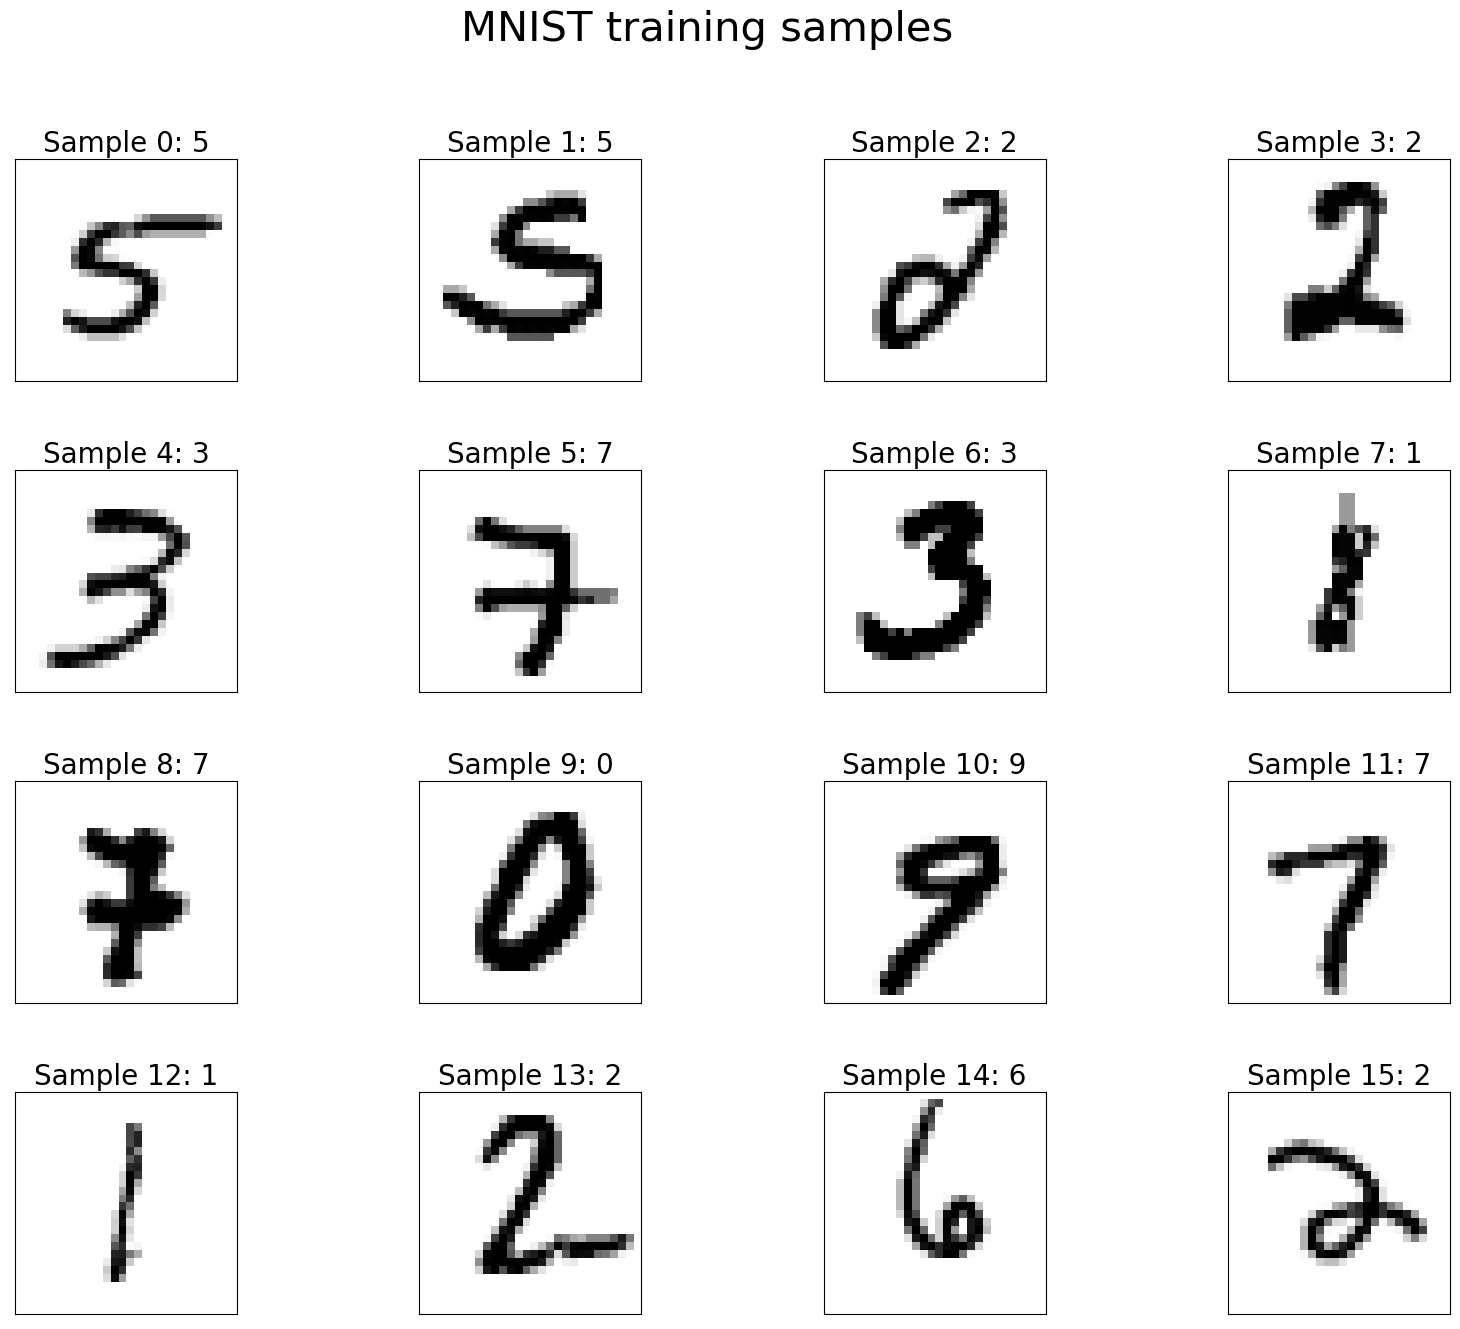

In [17]:
showImages(real_samples, true_labels = mnist_labels)

## Section 1: Train a GAN on MNIST for image generation
In this first part, you are asked to train and test a GAN for the generation of fake handwritten numbers (and letters). 

Let's just recall what training a model means in machine learning. It is in fact quite simple: given a model architecture, use an optimization scheme to minimize a loss function (representing the gap between the data and the model predictions) in order to find the optimal values of the model parameters. In this Section, all of these elements are treated one by one.

Moreover, you receive reference Generator and Discriminator architectures. These neural network architectures should not be changed. Indeed, they are sufficient in order to get nice enough results while keeping the training time reasonable on a laptop CPU (normally less than 2 hours training).

However, if you want to train additional Generator and/or Discriminator models that could be larger or smaller (for improved results or faster training for example), feel free to create them by yourself, explain them with comments and name them differently.

### 1.a Generator class
The Generator class takes an input: the dimension of the latent space. Indeed, the generator will create an image (1x28x28) from an input latent vector (1 color i.e. gray-scale, 28x28 pixels). Typically, this vector is of dimension 100 with each entry sampled from a standard normal distribution or from an uniform distribution on [-1,1]. You are free to change this dimension and see what happens.

The latent space is thus a space where the information contained in the images is compressed/condensed. This latent space will be the focus of the second part of the homework.

In [18]:
# Dimension of the latent space
# Predefined value = 100

dim_latent_space = 100

The class below contains the reference Generator architecture. You don't have to worry about the initialization of the model, it is done automatically.

This architecture should not be changed.

The Generator takes a batch of latent vectors as input, and ouputs one 1x28x28 pixels image for each input.

In [19]:
class Generator(nn.Module):

    def __init__(self, dim_latent_space):
        super().__init__()
        self.dim_latent_space = dim_latent_space
        self.fc = nn.Linear(self.dim_latent_space, 64*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.trans_conv2 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.trans_conv3 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.trans_conv4 = nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
    def forward(self, x):                   # Input = batch_size*dim_latent_space
        x = self.fc(x)                      # Output = batch_size*(64*7*7)
        x = x.view(-1, 64, 7, 7)            # Output = batch_size*64*7*7
        x = self.trans_conv1(x)             # Output = batch_size*64*14*14
        x = F.relu(self.batch_norm1(x))
        x = self.trans_conv2(x)             # Output = batch_size*32*14*14
        x = F.relu(self.batch_norm2(x))
        x = self.trans_conv3(x)             # Output = batch_size*16*14*14
        x = F.relu(self.batch_norm3(x))     
        x = self.trans_conv4(x)             # Output = batch_size*1*28*28
        x = torch.tanh(x)
        return x

In [20]:
generator = Generator(dim_latent_space).to(device=device)

### 1.b Discriminator class
The class below contains the reference Discriminator architecture. You don't have to worry about the initialization of the model, it is done automatically.

This architecture should not be changed.

The Discriminitor takes a batch of 1x28x28 pixels images as input, and ouputs numbers between -inf and +inf. The activation of the last layer represents some likelihood of the image being fake or not, according to the model. Afterwards, it goes through a sigmoid function in order to scale numbers between 0 and 1. An output of 0 means that the model is certain that the corresponding input image is fake, and an output of 1 means that it is certain that it is real.

In [21]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)     
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(128*7*7, 1)
    
    def forward(self, x):                               # Input = batch_size*1*28*28
        x = x.view(-1, 1, 28, 28)                       # Output = batch_size*1*28*28
        x = F.leaky_relu(self.conv0(x), 0.2)            # Output = batch_size*32*14*14
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)            # Output = batch_size*64*14*14
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)            # Output = batch_size*128*14*14
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)            # Output = batch_size*128*7*7
        x = self.conv3_drop(x)
        x = x.view(-1, 128*7*7)                         # Output = batch_size*(128*7*7)
        x = self.fc(x)                                  # Output = batch_size*1
        return x

In [22]:
discriminator = Discriminator().to(device=device)

### 1.c Number of parameters
This function counts and prints the number of parameters in any neural network model.

There should be no need to modify the function numberParameters.

In [23]:
def numberParameters(model, trainable = False, model_name = None):
    total_params = sum(param.numel() for param in model.parameters())
    if model_name != None:
        print("Number of parameters of " + model_name + ": " + str(total_params))
    return total_params

In [24]:
discriminator_params = numberParameters(discriminator, model_name = "discriminator")
generator_params = numberParameters(generator, model_name = "generator")

Number of parameters of discriminator: 246529
Number of parameters of generator: 377121


### 1.d Loss function
The loss function measures how good the model is. For the discriminator, it a binary classification problem: the discriminator tries to distinguish true data (label = 1) from fake generated ones (label = 0). Therefore, we use a Binary Cross Entropy loss. As the only goal of the generator is to fool the discriminator, it can also be expressed with a Binary Cross Entropy loss function. Think about what inputs we need to give to the loss function for the discriminator and for the generator.

You see that BCELoss is replaced by BCEWithLogitsLoss. Think about why this is, and how it links with the last layer of the given Discriminator architecture.

This loss function should not be changed.

In [25]:
# Loss function for the GAN

#loss_function_gan = nn.BCELoss()
loss_function_gan = nn.BCEWithLogitsLoss()

### 1.e Optimizers
Adam is one of the most famous adaptive stochastic gradient descent algorithm. It is massively used for training neural networks.

You can play around with the Adam parameters if you want.

In [26]:
# Adam optimization parameters
# Predefined values: lr_gan = 0.0002, betas_gan = (0.5, 0.999)
lr_gan = 2e-4
betas_gan = (0.5, 0.999)

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_gan, betas = betas_gan)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_gan, betas = betas_gan)

### 1.f Accuracy
We define one error measure as the accuracy reached by the discriminator for its predictions y_predicted, i.e. the ratio between the number of correct classifications and the total number of samples. We suppose that if 0.0 <= y_generated[i] <= 0.5, then it predicts a fake image and if 0.5 < y_generated[i] <= 1.0, it predicts a true image.

During the training, data are loaded batch by batch. It could thus be a good idea to consider that the inputs of the following function are the true and predicted labels from one batch of data.

Task: complete the computeGANAccuracy function.

In [27]:
def computeGANAccuracy(y_predicted,y_true):
    y_temp = np.copy(y_predicted)
    
    y_temp[y_temp <= .5] = 0. # Fake image
    y_temp[y_temp >.5] = 1.   # Real image
    
    accuracy = (y_temp == y_true).astype(float)
    accuracy = np.sum(accuracy)/accuracy.size
    
    return accuracy

### 1.g Preparing the training process
In this part, you are asked to initialize the training process (not the model which is initialized automatically). 

Let's just first define the number of iterations (epochs) that the training will last. Satisfactory results can be obtained with 5 epochs, but you can of course increase this value for a better training.

In [28]:
# Number of epochs for the training
# Predefined value: num_epochs_gan = 5

num_epochs_gan = 50

It is important to keep track of the evolution of the error metrics during the training process. A simple idea is to store the values of the metrics in arrays, at least after every epoch.

Task: Create arrays that will contain the accuracy for train and test sets, as well as the values of the discriminator loss and of the generator loss during the training. Compute the errors before training the model and store them in your arrays.

In [29]:
%%time
if TRAIN:
    # Error metrics at initialisation
    generator.eval()
    discriminator.eval()

    accuracies_train = np.zeros(num_epochs_gan + 1)
    accuracies_test  = np.zeros(num_epochs_gan + 1)

    losses_gen  = np.zeros(num_epochs_gan + 1)
    losses_disc = np.zeros(num_epochs_gan + 1)

    # TRAINING SET
    for batch_id, (real, _) in enumerate(train_loader):
            noise = torch.randn(batch_size, dim_latent_space).to(device)
            fake  = generator(noise).to(device) # Generator create images -> expected disc is a null vector
            real  = real.to(device) # Actual images -> expected disc is a vector full of ones

            disc_real = discriminator(real).to(device)
            disc_fake = discriminator(fake).to(device)

            # Expected accuracy ~50% if random
            accuracies_train[0] += 0.5 * computeGANAccuracy(disc_real.cpu().detach(), np.ones(disc_real.shape))
            accuracies_train[0] += 0.5 * computeGANAccuracy(disc_fake.cpu().detach(), np.zeros(disc_real.shape))

            loss_disc_fake = loss_function_gan(disc_fake, torch.zeros_like(disc_fake)).to(device)
            loss_disc_real = loss_function_gan(disc_real, torch.ones_like(disc_real)).to(device)

            losses_disc[0] += 0.5 * (loss_disc_real + loss_disc_fake).to(device)

            losses_gen[0] += loss_function_gan(disc_fake, torch.ones_like(disc_fake)).to(device)


    accuracies_train[0] /= n_batches_total
    losses_gen[0] /= n_batches_total
    losses_disc[0] /= n_batches_total

    # TEST SET
    for batch_id, (real, _) in enumerate(test_loader):
        noise = torch.randn(batch_size, dim_latent_space).to(device)
        fake  = generator(noise).to(device) # Generator create images -> expected disc is a null vector
        real = real.to(device)

        disc_real = discriminator(real).to(device)
        disc_fake = discriminator(fake).to(device)

        accuracies_test[0] += 0.5 * computeGANAccuracy(disc_real.cpu().detach(), np.ones(disc_real.shape))
        accuracies_test[0] += 0.5 * computeGANAccuracy(disc_fake.cpu().detach(), np.zeros(disc_fake.shape))

    accuracies_test[0] /= n_batches_total_test

    print("GAN performance before training\n")

    print(f"Accuracy of the discriminator during train: {accuracies_train[0] * 100:.2f}%")
    print(f"Accuracy of the discriminator during test:  {accuracies_test[0] * 100:.2f}%")
    print(f"Average discriminator loss during train: {losses_disc[0]:.2f}")
    print(f"Average generator loss during train: {losses_gen[0]:.2f}")

    _ = generator.train()
    _ = discriminator.train()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.39 µs


It is a good option to keep track of the evolution of the images generated through the training. Defining a reference sample of latent vectors allows to generate the image for the same inputs every time. You can compute the output from those vectors after each epoch to see how the generated images evolve with the training. The latent vectors can be generated from a standard normal distribution, or from a uniform distribution over [-1,1].

Task: Define a sample of reference latent vectors.

In [30]:
# Reference latent vectors

ref_latent = torch.randn(batch_size, dim_latent_space).to(device)


### 1.h Training and testing the GAN
This is finally the core part of this section: training your GAN.

The training will follow an easy structure. Here is the pseudo-code of the training process:


    for each epoch:

        for each batch:

            train the discriminator on the batch:

                generate fake data (same amount as size of the batch)

                predict if data from the batch and generated data are fake or not

                compute the discriminator loss function

                backpropagate the error in the discriminator

            train the generator on the batch

                generate fake data (same amount as size of the batch)

                predict if generated data are fake or not

                compute the generator loss function

                backpropagate the error in the generator

        end

    end

Task: Code the GAN training from the pseudo-code given above. Don't forget to switch between training and evaluation modes for the models, by using train() and eval() Pytorch functions. To understand what to do and why, look for their impact on specific layers of the networks. You may also use the time package in order to get information about the duration of the training. Finally, at every epoch, compute and store the accuracy and the losses of the model and generate images from your reference sample.

In [31]:
%%time
if TRAIN:
    # Training of the GAN

    for epoch in range(num_epochs_gan):
        generator.eval()
        discriminator.eval()

        gen = generator(ref_latent)
        disc = discriminator(gen)

        disc = disc.cpu().reshape((batch_size,))
        labels = [f"{p:.3f}->{p>0.5}" for p in disc]

        showImages(gen.cpu().detach(),generated=True, predicted=True, predicted_labels=labels, epoch=epoch + 1)

        for batch_id, (real, _) in enumerate(train_loader):
            real = real.to(device)
            noise = torch.randn(batch_size, dim_latent_space).to(device) #Noise to feed the generator
            fake = generator(noise).to(device)

            # Train the discriminator
            discriminator.train()
            ## Discriminate data
            disc_fake = discriminator(fake).to(device)
            disc_real = discriminator(real).to(device)

            ## Compute the loss
            loss_disc_fake = loss_function_gan(disc_fake, torch.zeros_like(disc_fake)).to(device)
            loss_disc_real = loss_function_gan(disc_real, torch.ones_like(disc_real)).to(device)

            loss_discriminator = 0.5 * (loss_disc_real + loss_disc_fake).to(device)

            ## Optimization
            optimizer_discriminator.zero_grad()
            loss_discriminator.backward()
            optimizer_discriminator.step()

            ## Metrics
            losses_disc[epoch+1] += loss_discriminator     
            accuracies_train[epoch+1] += 0.5 * computeGANAccuracy(disc_fake.cpu().detach(), np.zeros(disc_fake.shape))
            accuracies_train[epoch+1] += 0.5 * computeGANAccuracy(disc_real.cpu().detach(), np.ones(disc_real.shape))

            # Train Generator
            generator.train()
            discriminator.eval()
            ## Discriminate the fake data
            noise = torch.randn(batch_size, dim_latent_space).to(device) #Noise to feed the generator
            fake = generator(noise).to(device)
            disc_fake = discriminator(fake).to(device)

            ## Compute loss
            loss_generator  = loss_function_gan(disc_fake, torch.ones_like(disc_fake)).to(device)

            ## Update of the generator
            optimizer_generator.zero_grad()
            loss_generator.backward()
            optimizer_generator.step()

            ## Metrics
            losses_gen[epoch+1] += loss_generator


            ## TRAIN LOG
            if batch_id == 0:
                print(f"Epoch [{epoch + 1:2d}/{num_epochs_gan:2d}] \
                        Batch {batch_id + 1:4d}/{len(train_loader)} \
                        Loss D: {loss_discriminator:.4f}, loss G: {loss_generator:.4f}")

                s = f"Epoch [{epoch + 1:2d}/{num_epochs_gan:2d}]"
                s = " " * len(s)
            elif (batch_id%750 == 0) or (batch_id + 1 == len(train_loader)):
                print(f"{s} \
                        Batch {batch_id + 1:4d}/{len(train_loader)} \
                        Loss D: {loss_discriminator:.4f}, loss G: {loss_generator:.4f}")


        accuracies_train[epoch+1] /= n_batches_total
        losses_gen[epoch+1] /= n_batches_total
        losses_disc[epoch+1] /= n_batches_total

        generator.eval()
        discriminator.eval()
        for batch_id, (real, _) in enumerate(test_loader):
            noise = torch.randn(batch_size, dim_latent_space).to(device)
            fake  = generator(noise).to(device) # Generator create images -> expected disc is a null vector
            real = real.to(device)

            disc_real = discriminator(real).to(device)
            disc_fake = discriminator(fake).to(device)

            accuracies_test[epoch+1] += 0.5 * computeGANAccuracy(disc_real.cpu().detach(), np.ones(disc_real.shape))
            accuracies_test[epoch+1] += 0.5 * computeGANAccuracy(disc_fake.cpu().detach(), np.zeros(disc_fake.shape))

        accuracies_test[epoch+1] /= n_batches_total_test

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


### 1.i Plot the results
You should plot the evolution of your error metrics (accuracy and loss function) in function of the number of epochs, to see how efficient the training is. Show the evolution of the images generated from your reference sample as well.

Task: Make those plots, as clean and readable as possible.

In [32]:
if TRAIN:
    # Plots of accuracy and of loss function, images generated from your reference sample.
    epochs = np.arange(num_epochs_gan+1)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,18))

    ax1.plot(epochs, accuracies_train, label = "Error during training")
    ax1.plot(epochs, accuracies_test, label = "Error during test")
    ax1.set_title('Accuracies')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(epochs, losses_disc)
    ax2.set_title('Discriminer loss')
    ax2.set_xlabel('Epoch')

    ax3.plot(epochs, losses_gen)
    ax3.set_title('Generator loss')
    ax3.set_xlabel('Epoch')

    for ax in (ax1, ax2, ax3):
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    plt.savefig("./Figures/Metrics")

    gen = generator(ref_latent)

    disc = discriminator(gen)

    showImages(gen.cpu().detach(), generated=True, epoch="final")

### 1.j Save your models
A really useful feature for your experiments is to be able to save your models. This can be done with the torch.save function. In the function saveModel, a model is stored in the folder ./Models that you may want to create. The (date)time is used to always store your models with a different name and never lose some training that you would have done.

Be careful however: the saveModel function below stores the "state dictionary" of your model, not your model itself. 

You can of course modify the function saveModel as you wish.

In [33]:
! mkdir Models

mkdir: cannot create directory ‘Models’: File exists


In [34]:
def saveModel(model, model_name):
    now = datetime.now().strftime("%Y_%m_%d__%H_%M")
    torch.save(model.state_dict(), './Models/' + model_name + '__' + now)

### 1.k Load your models
You can also load models that you trained and saved earlier with the function loadModel.

However, be careful. You will have to first recreate a new instance of your class, and then import the state dictionary in the new instance. This means that the characteristics of your class should not have changed since then. In particular, the number of layers and the size of the layers need to match between the trained model and the most recent class in order to correctly assign the stored parameters. Moreover, there could be some trouble if you changed functions/methods from the class. 

You can of course modify the function loadModel as you wish.

In [35]:
def loadModel(model, model_name, date_time):
    model.load_state_dict(torch.load('./Models/' + model_name + '__' + date_time))
    model.eval()
    return model

_ = loadModel(generator, "Generator", "50__2472")
_ = loadModel(discriminator, "Discriminator", "50__2472")

## Section 2: Train a CNN on MNIST for image classification
In this second part, you are asked to train and test a CNN for the classification of handwritten numbers (and letters).

Therefore, you receive a reference CNN architecture that should not be changed. Training your CNN should be faster than training your GAN, so there is no fear about that.

However, if you want to train additional CNN models (for improved results or faster training for example), feel free to create them by yourself and name the classes differently.

### 2.a Number of classes
For classification task, it is of course necessary to know the number of classes possible. 

For the rest of the homework, pay attention not to confuse the label class (ex: the image represents a 2) and a model class (ex: the model is an instance of the CNN class).

There should be no need to modify the function numberClasses.

In [36]:
def numberClasses(dataset):
    n_classes = len(dataset.classes)
    return n_classes

In [37]:
n_classes = numberClasses(train_set)

### 2.b CNN class
The class below contains the reference CNN architecture. You don't have to worry about the initialization of the model, it is done automatically.

This architecture should not be changed.

The CNN architecture is defined by the number of classes. Indeed, for each entry it outputs a vector of size n_classes with values between -inf and +inf. This vector can be passed through the function scaleToProbabilities in order to get scaled and become somewhat interpretable as probabilities of belonging to one class. The function predictLabels extends the scaleToProbabilities function and selects the most activated/highest valued class as the CNN prediction.

There should be no need to modify the functions scaleToProbabilities and predictLabels, except playing with the scale_factor.

In [2]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Sequential(             # Images input is batch_size*1*28*28
            nn.Conv2d(1, 16, 5, 1, 2),          # Output is batch_size*16*28*28
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),        # Output is batch_size*16*14*14
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),         # Output is batch_size*32*14*14
            nn.ReLU(),                      
            nn.MaxPool2d(2),                    # Output is batch_size*32*7*7
        )
        # fully connected layer, output one number for each class
        self.out = nn.Sequential(         
            nn.Linear(32 * 7 * 7, self.n_classes),          # Output is batch_size*n_classes
        )
    
    def scaleToProbabilities(self, outmap, scale_factor = 3): 
        # scale_factor allows to scale your output before passing it into the softmax function 
        # in order to get numbers interpratble as probabilities
        
        flattened_outmap = outmap.view(outmap.shape[0], -1)
        outmap_std = torch.std(flattened_outmap, dim = 1).view(-1, 1)
        outmap_scaled_std = torch.div(outmap, outmap_std)
        probabilities = nn.functional.softmax(outmap_scaled_std*scale_factor, dim=1)
        return probabilities
    
    def predictLabels(self, outmap, scale_factor = 3):
        probabilities = self.scaleToProbabilities(outmap, scale_factor = 3)
        certainty, predicted_labels = torch.max(probabilities, 1)
        predicted_labels = predicted_labels.data.squeeze()
        certainty = certainty.data.squeeze()
        return predicted_labels, probabilities, certainty
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), 32 * 7 * 7)
        output = self.out(x)
        return output

In [39]:
cnn = CNN(n_classes).to(device=device)
cnn_params = numberParameters(cnn, model_name = "classifier")

Number of parameters of classifier: 28938


### 2.c Loss function
For classification tasks, the main loss function used is Cross Entropy. As entries, it takes the activations of last layer nodes  and the true labels of data (between 0 and n_classes-1). 

This loss function should not be changed.

In [40]:
# Loss function for the CNN

loss_function_cnn = nn.CrossEntropyLoss()

### 2.d Optimizer
Again, we will use Adam as an optimizer.

You can play around with the Adam parameters if you want.

In [41]:
# Adam optimization parameters
# Predefined values: lr_cnn = 0.01, betas_cnn = (0.9, 0.999)
lr_cnn = 0.01
betas_cnn = (0.9, 0.999)

optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=lr_cnn, betas = betas_cnn)

### 2.e Accuracy
We define one error measure as the accuracy reached by the CNN for its classifying predictions. In particular, we call accuracy the ratio between the number of correct classifications and the number of samples. We assume that the most activated output corresponds to the class prediction.

During the training, data are loaded batch by batch. It could thus be a good idea to consider that the inputs of the following function are the true and predicted labels from one batch of data.

Task: complete the computeCNNAccuracy function.

In [42]:
def computeCNNAccuracy(y_predicted,y_true):
    accuracy = 0.0
    accuracy = torch.sum(y_predicted == y_true).item()/y_true.shape[0]
    return accuracy

### 2.f Preparing the training process
In this part, you are asked to initialize the training process (not the model which is initialized automatically). 

Let's just first define the number of iterations (epochs) that the training will last. Satisfactory results can be obtained with 15 epochs, but you can of course increase this value for a better training.

In [43]:
# Number of epochs for the training
# Predefined value: num_epochs_cnn = 15

num_epochs_cnn = 20

It is important to keep track of the evolution of the error metrics during the training process. A simple idea is to store the values of the metrics in arrays, at least after every epoch.

Task: Create arrays that will contain the accuracy for train and test sets, as well as the values of the CNN loss during the training. Compute the errors before training the model and store them in your arrays.

In [44]:
%%time
if TRAIN:    
    # Error metrics at initialisation

    losses_train_cnn     = np.zeros(num_epochs_cnn+1)
    accuracies_train_cnn = np.zeros(num_epochs_cnn+1)
    accuracies_test_cnn  = np.zeros(num_epochs_cnn+1)

    cnn.eval()
    for batch_id, (real, labels) in enumerate(train_loader):
        real = real.to(device)
        labels = labels.to(device)

        pred = cnn(real)

        labels_pred, labels_prob, _ = cnn.predictLabels(pred)

        target_prob = torch.zeros_like(labels_prob)
        for i,j in enumerate(labels):
            target_prob[i][j] = 1
        target_prob = target_prob.to(device)

        loss_cnn = loss_function_cnn(labels_prob, target_prob)

        losses_train_cnn[0] += loss_cnn.item()
        accuracies_train_cnn[0] += computeCNNAccuracy(labels_pred, labels)

    accuracies_train_cnn[0] /= n_batches_total
    losses_train_cnn[0] /= n_batches_total

    cnn.eval()
    for batch_id, (real, labels) in enumerate(test_loader):
        real = real.to(device)
        labels = labels.to(device)
        pred = cnn(real)

        labels_pred, _, _ = cnn.predictLabels(pred)

        accuracies_test_cnn[0] += computeCNNAccuracy(labels_pred, labels)

    accuracies_test_cnn[0] /= n_batches_total_test

    print(f"Accuracy during training: {accuracies_train_cnn[0]*100:.2f}%")
    print(f"Accuracy during test:     {accuracies_test_cnn[0]*100:.2f}%")
    print(f"Loss during training:     {losses_train_cnn[0]:.2f}")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs


### 2.g Training and testing the CNN
This is finally the core part of this section: training your CNN.

The training will follow an easy structure. Here is the pseudo-code of the training process:

    for each epoch:

        for each batch:

            train the classifier on the batch:

                predict the labels

                compute the classifier loss function

                backpropagate the error in the cnn
                
        end

    end

Task: Code the CNN training from the pseudo-code given above. Don't forget to switch between training and evaluation modes for the model, by using train() and eval() Pytorch functions. You may also use the time package in order to get information about the duration of the training. Finally, at every epoch, compute and store the accuracy and the loss of the model and generate images from your reference sample.

In [45]:
%%time
if TRAIN:
    # Training of the CNN
    for epoch in range(num_epochs_cnn):
        cnn.train()
        cnn.eval()
        for batch_id, (real, labels) in enumerate(train_loader):
            real = real.to(device)
            labels = labels.to(device)

            pred = cnn(real)

            labels_pred, labels_prob, _ = cnn.predictLabels(pred)

            target_prob = torch.zeros_like(labels_prob)
            for i,j in enumerate(labels):
                target_prob[i][j] = 1
            target_prob = target_prob.to(device)

            loss_cnn = loss_function_cnn(labels_prob, target_prob)

            optimizer_cnn.zero_grad()
            loss_cnn.backward()
            optimizer_cnn.step()

            losses_train_cnn[epoch + 1] += loss_cnn.item()
            accuracies_train_cnn[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

        accuracies_train_cnn[epoch + 1] /= n_batches_total
        losses_train_cnn[epoch + 1] /= n_batches_total

        cnn.eval()
        for batch_id, (real, labels) in enumerate(test_loader):
            real = real.to(device)
            labels = labels.to(device)
            pred = cnn(real)

            labels_pred, _, _ = cnn.predictLabels(pred)

            accuracies_test_cnn[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

        accuracies_test_cnn[epoch + 1] /= n_batches_total_test

        print(f"Epoch [{epoch + 1:2d}/{num_epochs_cnn:2d}] \
                Accuracy: {accuracies_test_cnn[epoch + 1]:.4f}")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


### 2.h Plot the results
Again, you should plot the evolution of your error metrics (accuracy and loss function) in function of the number of epochs, to see how efficient the training is. Show the evolution of the images generated from your reference sample as well.

Task: Make those plots, as clean and readable as possible.

In [46]:
if TRAIN:
    # Plots of accuracy and of loss function, images generated from your reference sample.
    epochs = np.arange(num_epochs_cnn+1)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

    ax1.plot(epochs, accuracies_train_cnn, label = "Error during training")
    ax1.plot(epochs, accuracies_test_cnn, label = "Error during test")
    ax1.set_title('Accuracies')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(epochs, losses_train_cnn)
    ax2.set_title('CNN loss')
    ax2.set_xlabel('Epoch')


    for ax in (ax1, ax2):
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    plt.savefig("./Figures/CNN_Metrics.png")


# Section 3. Explore the latent space

In [47]:
# Load models
dim_latent_space = 100
discriminator = Discriminator().to(device=device)
generator = Generator(dim_latent_space).to(device=device)
cnn = CNN(n_classes).to(device=device)

def loadModel(model, model_name, date_time):
    model.load_state_dict(torch.load('./Models/' + model_name + '__' + date_time))
    model.eval()
    return model

_ = loadModel(generator, "Generator", "50__2472")
_ = loadModel(discriminator, "Discriminator", "50__2472")
_ = loadModel(cnn, "CNN", "50__2472")

## 3.1 Combine your generator and your classifier

In part 1, you have created a functional generative model and an efficient classifier. You will now use both
models to generate images from the labels you want. To solve this GAN inversion task, you will proceed in two
steps.

First step: you generate a lot of triplets (latent vector, generated image, predicted label). To do so, you randomly
generate latent vectors, which you pass in your generator to create the corresponding images, and then give the
latter to your classifier to get its predicted labels.

In [48]:
# Number of generated latent vectors

In [79]:
n_latent_vectors = 10_000

latents = torch.randn(n_latent_vectors, dim_latent_space).to(device) #Noise to feed the generator
imgs   = generator(latents).to(device)
labels, _, certainty  = cnn.predictLabels(cnn(imgs))

OutOfMemoryError: CUDA out of memory. Tried to allocate 480.00 MiB (GPU 0; 5.80 GiB total capacity; 3.63 GiB already allocated; 433.62 MiB free; 4.08 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Second step: select the images with the highest quality, i.e. the ones looking visually the most like true data.
An idea to find them is to keep only the labels predicted with high probability, as they should be the most
unambiguous ones. For example, you could set a minimum threshold on the prediction ”certainty” (defined in part
1 as the ”probability”/output of the most activated label in your classifier last layer). We will call these ”labelled
latent vectors”. Notice that this achieves the goal: by choosing vectors with the desired label, you can generate any
message you want!

In [80]:
# Latent set wihtout any filtering
threshold = 0
mask = certainty >= threshold
latents   = latents[mask]
imgs      = imgs[mask]
certainty = certainty[mask]
labels    = labels[mask]

IndexError: The shape of the mask [5461] at index 0 does not match the shape of the indexed tensor [10000, 100] at index 0

In [51]:
# Get one image per label sorted by CNN certainty
latents_best = [0. for i in range(10)]
imgs_best = [0. for i in range(10)]
for label in range(10):
    mask = labels==label
    latents_masked   = latents[mask]
    imgs_masked      = imgs[mask]
    certainty_masked = certainty[mask]
    labels_masked    = np.full(certainty_masked.shape, label)
    
    index = np.argmax(certainty_masked.cpu().detach().numpy())
    best_latent = latents_masked[index]
    best_img = imgs_masked[index].cpu()
    
    latents_best[label] = best_latent
    imgs_best[label] = best_img
    
latents_best = torch.vstack(latents_best).to(device)
imgs_best = torch.vstack(imgs_best).to(device)

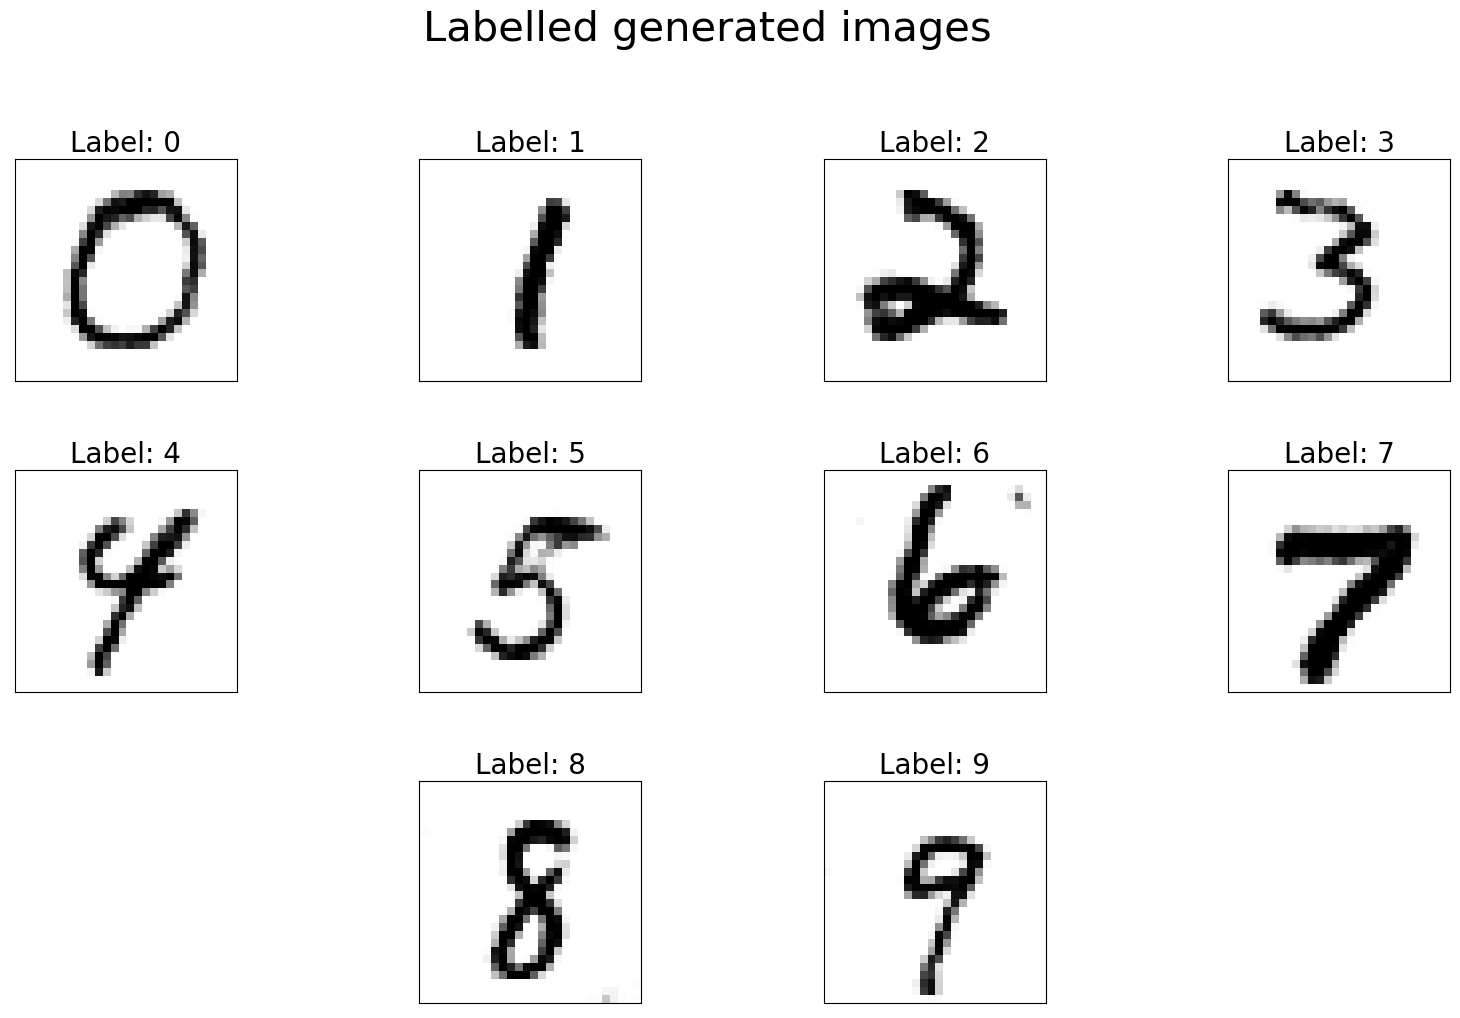

In [52]:
# Plot the best generated labels as example
f = plt.figure("Labelled generated images", figsize = (20,15))
f.suptitle("Labelled generated images", fontsize = 30)

f.subplots_adjust(wspace=0.2, hspace=0.4)
plt.rc('axes', titlesize=20)

for i in range(10):
        if i < 8: fi = f.add_subplot(4, 4, i + 1)
        else: fi = f.add_subplot(4, 4, i + 2) # For esthetic purposes, it centers the last row
            
        fi.imshow(imgs_best[i].cpu().detach().numpy().reshape(28, 28), cmap="gray_r")
        
        plt.xticks([])
        plt.yticks([]) 
        
        fi.title.set_text(f"Label: {i}")

plt.savefig("./Figures/labelled_generated.png")

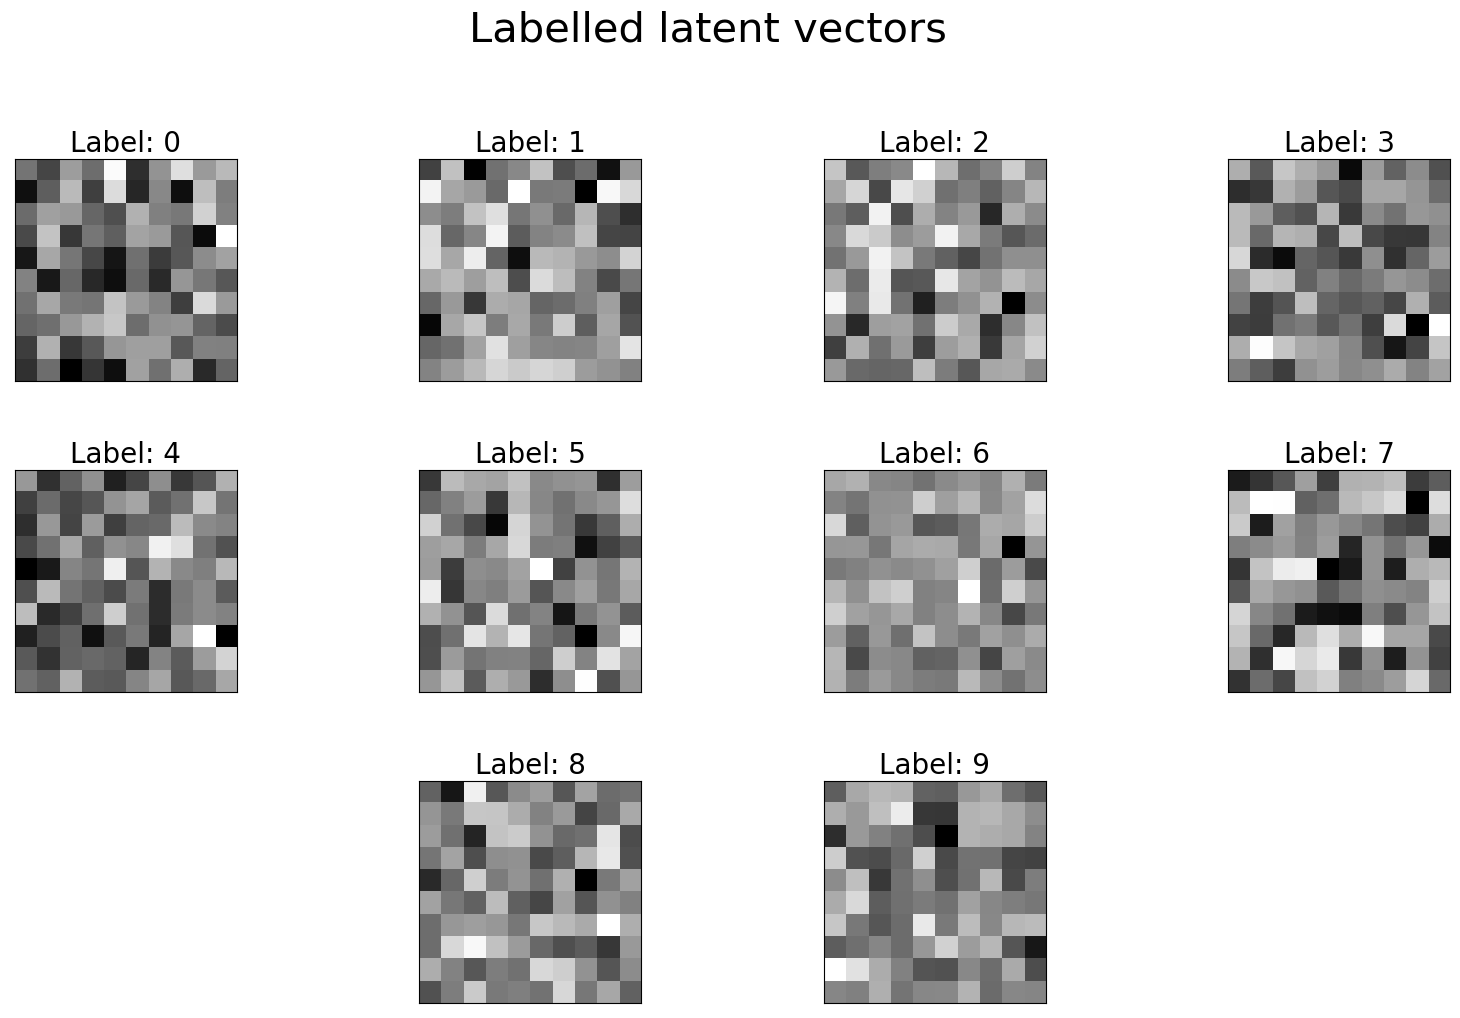

In [53]:
f = plt.figure("Labelled latent vectors", figsize = (20,15))
f.suptitle("Labelled latent vectors", fontsize = 30)

f.subplots_adjust(wspace=0.2, hspace=0.4)
plt.rc('axes', titlesize=20)

for i in range(10):
        if i < 8: fi = f.add_subplot(4, 4, i + 1)
        else: fi = f.add_subplot(4, 4, i + 2) # For esthetic purposes, it centers the last row
        
        fi.imshow(latents_best[i].cpu().detach().numpy().reshape(10, 10), cmap="gray_r")
        
        plt.xticks([])
        plt.yticks([]) 
        
        fi.title.set_text(f"Label: {i}")

plt.savefig("./Figures/labelled_latent_vectors.png")

## 3.2 Distribution of classes
Generate a lot of labelled latent vectors and count the proportion of each class. Are all labels represented? Are
they represented equally? How does the certainty threshold influence that repartition? Explain and don’t forget
to report your experiment parameters (dataset, latent vector generating distribution, number of samples, certainty
threshold).

In [54]:
n_gan = np.zeros(10) # Number of occurence of the label in the gan generated image
p_gan = np.zeros(10) # Probability of occurence of the label in the gan generated image

set_size = latents.shape[0]

print(f"Out of {n_latent_vectors} latent vectors, only {set_size} remain using a certainty threshold of {threshold}.\n")
print("The probability of occurence of the different labels in the unfiltered GAN are:")
for i in range(10):
    n_gan[i] = torch.sum((labels==i).int())
    p_gan[i] = n_gan[i]/set_size 
    print(f" P(label={i}) = {p_gan[i]*100:5.2f}%")

Out of 10000 latent vectors, only 10000 remain using a certainty threshold of 0.

The probability of occurence of the different labels in the unfiltered GAN are:
 P(label=0) =  9.29%
 P(label=1) = 12.61%
 P(label=2) =  7.97%
 P(label=3) = 12.04%
 P(label=4) = 10.34%
 P(label=5) =  7.78%
 P(label=6) =  9.23%
 P(label=7) = 11.58%
 P(label=8) =  7.79%
 P(label=9) = 11.37%


In [55]:
n_mnist = np.zeros(10) # Number of occurence of the label in the MNIST set
p_mnist = np.zeros(10) # Probability of occurence of the label in the MNIST set

set_size = train_set.targets.shape[0] + test_set.targets.shape[0]
print("The probability of occurence of the different labels in the MNIST set are:")
for i in range(10):
    n_mnist[i] += np.sum((train_set.targets.numpy() == i).astype(int))
    n_mnist[i] += np.sum((test_set.targets.numpy() == i).astype(int))
    
    p_mnist[i] = n_mnist[i]/set_size
    
    print(f" P(label={i}) = {p_mnist[i]*100:5.2f}%")


The probability of occurence of the different labels in the MNIST set are:
 P(label=0) =  9.86%
 P(label=1) = 11.25%
 P(label=2) =  9.99%
 P(label=3) = 10.20%
 P(label=4) =  9.75%
 P(label=5) =  9.02%
 P(label=6) =  9.82%
 P(label=7) = 10.42%
 P(label=8) =  9.75%
 P(label=9) =  9.94%


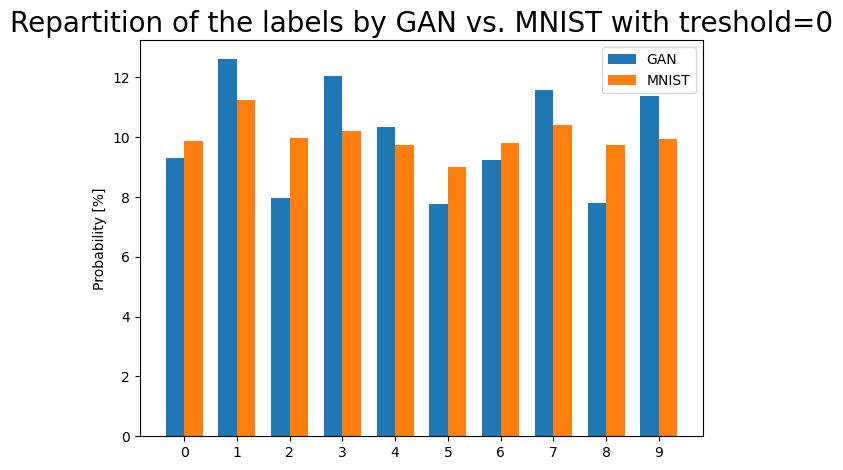

In [56]:
# Plot the comparative repartition of the label between
# Unfiltered GAN and MNIST Set

x = np.arange(10)  # the label locations
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, p_gan*100, width, label='GAN')
rects2 = ax.bar(x + width/2, p_mnist*100, width, label='MNIST')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability [%]')
ax.set_title(f'Repartition of the labels by GAN vs. MNIST with treshold={threshold}')
ax.set_xticks(x, x)
ax.legend()

fig.tight_layout()

plt.savefig("./Figures/labels_repartition_threshold_0")
plt.show()

In [57]:
# Filtering the dataset to keep the best of the best of the generated latent vectors

threshold = 0.995

mask = certainty >= threshold
latents   = latents[mask]
imgs      = imgs[mask]
certainty = certainty[mask]
labels    = labels[mask]

print(f"{len(latents - n_latent_vectors)} were removed during the filtering")

5461 were removed during the filtering


In [58]:
n_gan = np.zeros(10) # Number of occurence of the label in the MNIST set
p_gan = np.zeros(10) # Probability of occurence of the label in the MNIST set

set_size = latents.shape[0]
print(f"Out of {n_latent_vectors} latent vectors, only {set_size} remain using a certainty threshold of {threshold}.\n")
print("The probability of occurence of the different labels in the filtered GAN are:")
for i in range(10):
    n_gan[i] = torch.sum((labels==i).int())
    p_gan[i] = n_gan[i]/set_size 
    
    print(f" P(label={i}) = {p_gan[i]*100:5.2f}%")

Out of 10000 latent vectors, only 5461 remain using a certainty threshold of 0.995.

The probability of occurence of the different labels in the filtered GAN are:
 P(label=0) = 10.33%
 P(label=1) = 17.12%
 P(label=2) =  6.37%
 P(label=3) = 10.64%
 P(label=4) = 10.64%
 P(label=5) =  5.77%
 P(label=6) =  9.72%
 P(label=7) = 12.95%
 P(label=8) =  6.32%
 P(label=9) = 10.14%


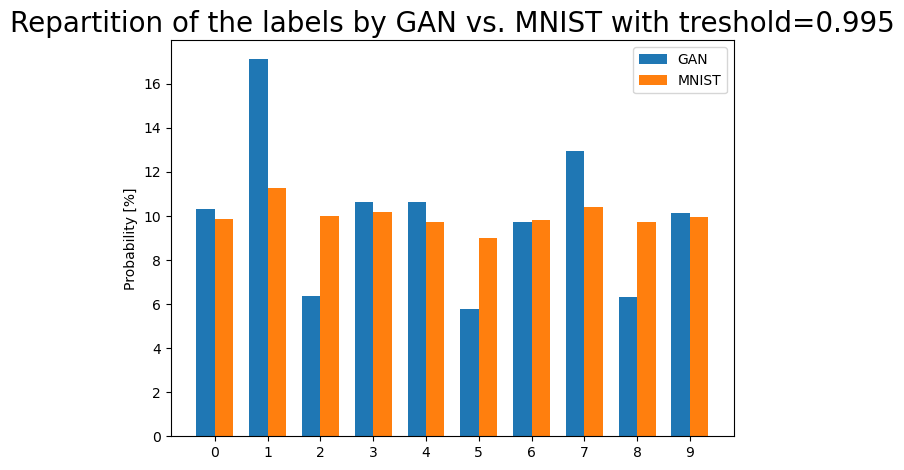

In [59]:
# Plot the comparative repartition of the label between
# Filtered GAN and MNIST Set

x = np.arange(10)  # the label locations
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, p_gan*100, width, label='GAN')
rects2 = ax.bar(x + width/2, p_mnist*100, width, label='MNIST')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability [%]')
ax.set_title(f'Repartition of the labels by GAN vs. MNIST with treshold={threshold}')
ax.set_xticks(x, x)
ax.legend()

fig.tight_layout()

plt.savefig("./Figures/labels_repartition_threshold_0.995.png")
plt.show()

## 3.3 Mean of your latent vectors
Take the mean of your labelled latent vectors from each class, we call these new vectors ”mean latent vectors”.
Show the corresponding images. Are these results better than the ones from before? Comment briefly.

In [60]:
latents_avg = torch.vstack([torch.mean(latents[labels==i], axis=0) for i in range(10)])
latents_avg = latents_avg.to(device)
imgs_avg = generator(latents_avg)

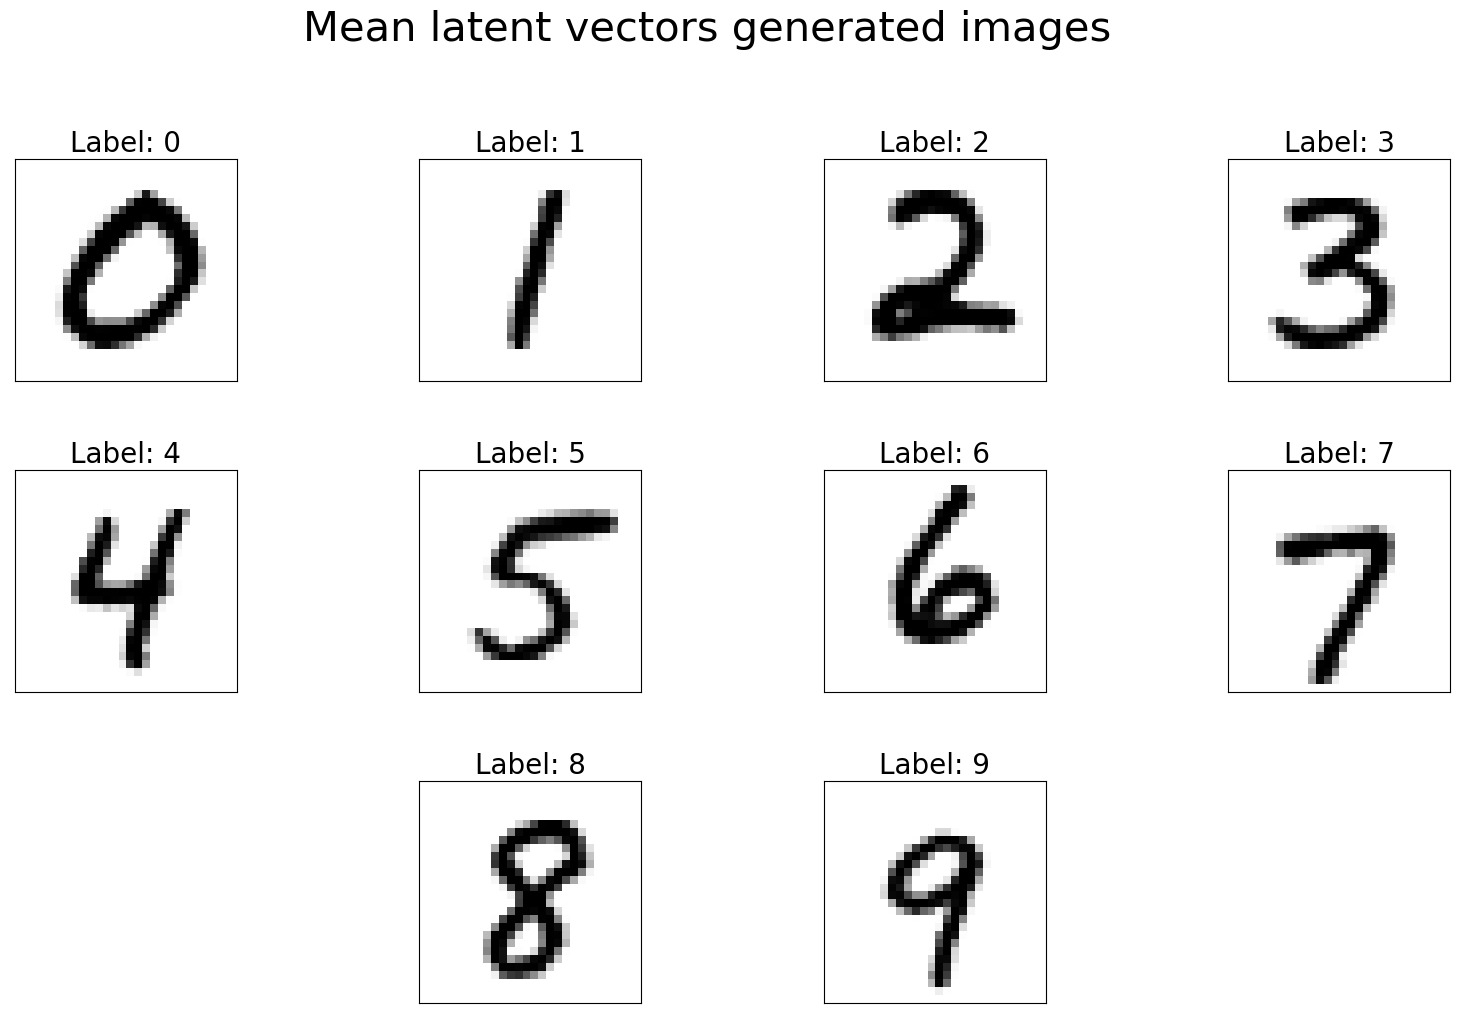

In [61]:
imgs_avg_numpy = imgs_avg.cpu().detach().numpy()
f = plt.figure("Mean latent vectors generated images", figsize = (20,15))
f.suptitle("Mean latent vectors generated images", fontsize = 30)

f.subplots_adjust(wspace=0.2, hspace=0.4)
plt.rc('axes', titlesize=20)

for i in range(10):
        if i < 8: fi = f.add_subplot(4, 4, i + 1)
        else: fi = f.add_subplot(4, 4, i + 2) # For esthetic purposes, it centers the last row
            
        fi.imshow(imgs_avg_numpy[i].reshape(28, 28), cmap="gray_r")
        plt.xticks([])
        plt.yticks([]) 
        
        fi.title.set_text(f"Label: {i}")

plt.savefig("./Figures/mean_generated.png")

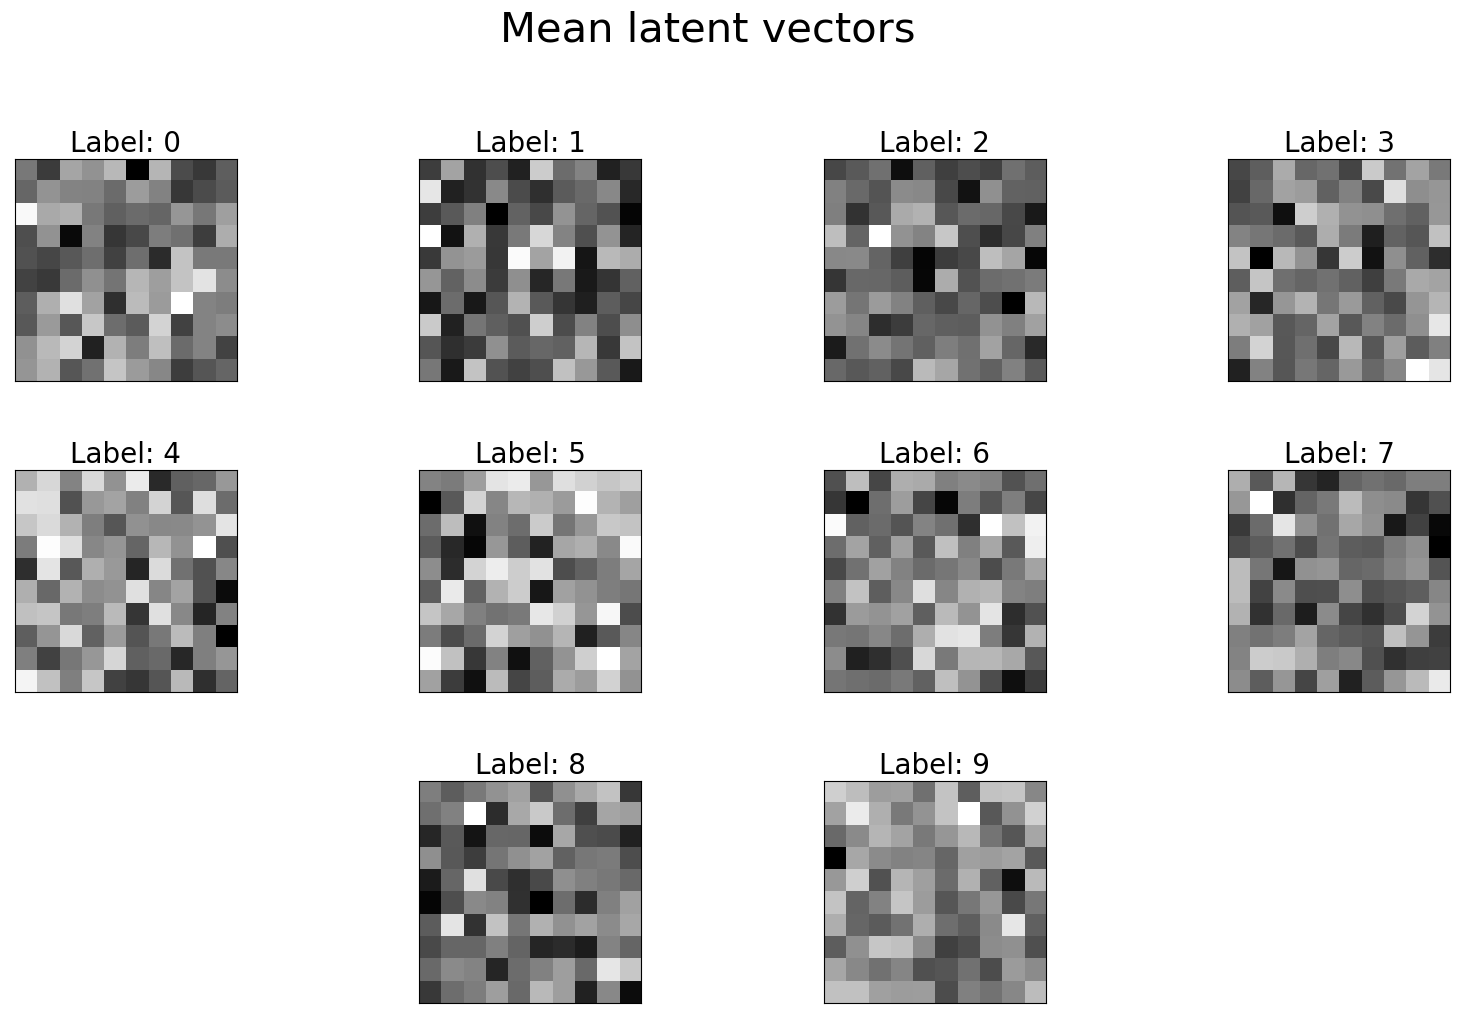

In [62]:
latents_avg_numpy = latents_avg.cpu().detach().numpy()

f = plt.figure("Mean latent vectors", figsize = (20,15))
f.suptitle("Mean latent vectors", fontsize = 30)

f.subplots_adjust(wspace=0.2, hspace=0.4)
plt.rc('axes', titlesize=20)

for i in range(10):
        if i < 8: fi = f.add_subplot(4, 4, i + 1)
        else: fi = f.add_subplot(4, 4, i + 2) # For esthetic purposes, it centers the last row
            
        fi.imshow(latents_avg_numpy[i].reshape(10, 10), cmap="gray_r")
        plt.xticks([])
        plt.yticks([]) 
        
        fi.title.set_text(f"Label: {i}")#.detach().numpy()))

plt.savefig("./Figures/mean_latent_vectors.png")

## 3.4 Norms and distances
Compute the norms of randomly generated latent vectors such as the labelled latent vectors. Compute the
norms of the mean latent vectors. How to explain the observed gap?
Compute the distances between labelled latent vectors and the mean latent vectors of each class. What do
you observe? This brings you to consider classifying to the nearest mean vector, which is known as Minimum
Distance to Mean (MDM) classification [8]. Compare MDM (criterion = minimum distance mean vectors) and
CNN classification (criterion = maximum activation of the last layer). Do both classifiers agree? Try with different
values of the certainty threshold.

In [63]:
# norm of the mean latent vectors
latents_avg_norms = torch.norm(latents_avg, dim=1).to(device)
print("Norm of the mean latent vectors:")
for i in range(latents_avg_norms.shape[0]):
    print(f"Label {i}: {latents_avg_norms[i]:10.7f}")

print()

# norm of random latent vectors
latents_norms = torch.norm(latents_best, dim=1).to(device)
print("Norm of random latent vectors:")
for i in range(latents_norms.shape[0]):
    print(f"Label {i}: {latents_norms[i]:10.7f}")

Norm of the mean latent vectors:
Label 0:  1.8349073
Label 1:  1.7241861
Label 2:  1.9161639
Label 3:  1.7611191
Label 4:  1.7917889
Label 5:  1.8808932
Label 6:  1.8988754
Label 7:  1.7924494
Label 8:  1.6643914
Label 9:  1.4903435

Norm of random latent vectors:
Label 0: 10.0121832
Label 1:  9.8389339
Label 2: 10.7989845
Label 3: 10.3574228
Label 4:  9.9222679
Label 5:  8.7004433
Label 6: 11.5212412
Label 7:  9.7421646
Label 8:  9.1501942
Label 9: 10.2548532


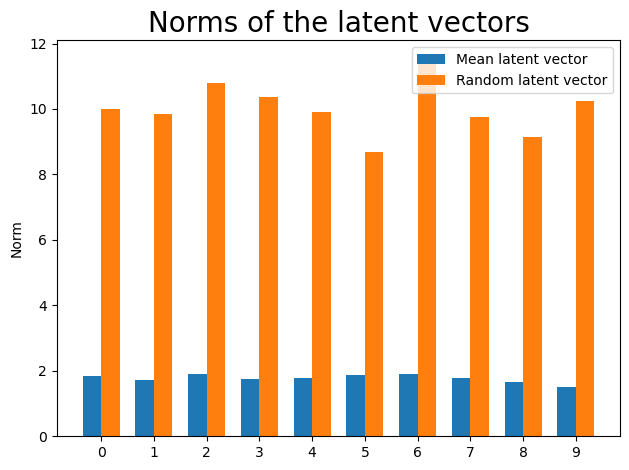

In [64]:
# Plot the comparative norms between
# Mean latents vectors and random latent vectors

x = np.arange(10)  # the label locations
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, latents_avg_norms.cpu().detach().numpy(), width, label='Mean latent vector')
rects2 = ax.bar(x + width/2, latents_norms.cpu().detach().numpy(), width, label='Random latent vector')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Norm')
ax.set_title(f'Norms of the latent vectors')
ax.set_xticks(x, x)
ax.legend()

fig.tight_layout()

plt.savefig("./Figures/latents_norms_comparison.png")
plt.show()

In [65]:
avg_rand_distances = torch.pairwise_distance(latents_avg, latents_best)

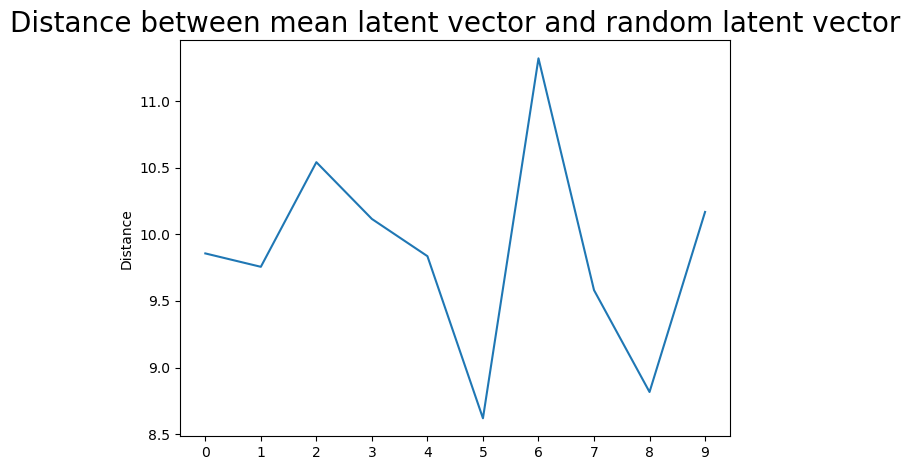

In [66]:
# Plot the distances between
# Mean latents vectors and random latent vectors

x = np.arange(10)  # the label locations
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
ax.plot(x, avg_rand_distances.cpu().detach().numpy())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Distance')
ax.set_title(f'Distance between mean latent vector and random latent vector')
ax.set_xticks(x, x)

fig.tight_layout()

plt.savefig("./Figures/latents_distances.png")
plt.show()

In [67]:
class MDMClassifier():
    def __init__(self, mean_vectors, device):
        self.mean_vectors = mean_vectors.cpu()
        self.device = device
    
    def __call__(self, vector):
        dist = torch.pairwise_distance(self.mean_vectors.to(self.device), vector.to(self.device)).cpu().detach().numpy()
        dist = np.abs(dist)

        return np.argmin(dist)

In [68]:
mdm = MDMClassifier(latents_avg, device)

In [69]:
mdm_accuracy = 0

for i in range(latents.shape[0]):
    mdm_pred = mdm(latents[i])
    cnn_pred = labels[i]
    mdm_accuracy += mdm_pred == cnn_pred.int()

print(f"MDM classifier agrees with cnn {float(mdm_accuracy/latents.shape[0]) * 100: .2f}% of the time")

MDM classifier agrees with cnn  85.26% of the time


## 3.5 Interpolation for exploration

The goal is to examine how digits (or letters) transform one into the other according to your model. First,
within the same class, then from one class to another.
First, choose two triplets within the same class that you find visually satisfying. We call those latent vectors
”extreme latent vectors”. Then, create intermediate triplets by interpolating linearly between the extreme latent
vectors. Show how one image evolves into the other one by linear interpolation in the latent space. Compare the
interpolants to the extremes, for 3 distinct examples.
Now, choose two extreme latent vectors from different classes (for example, corresponding to two mean latent
vectors). Then, repeat the instructions from above for these new extreme latent vectors.


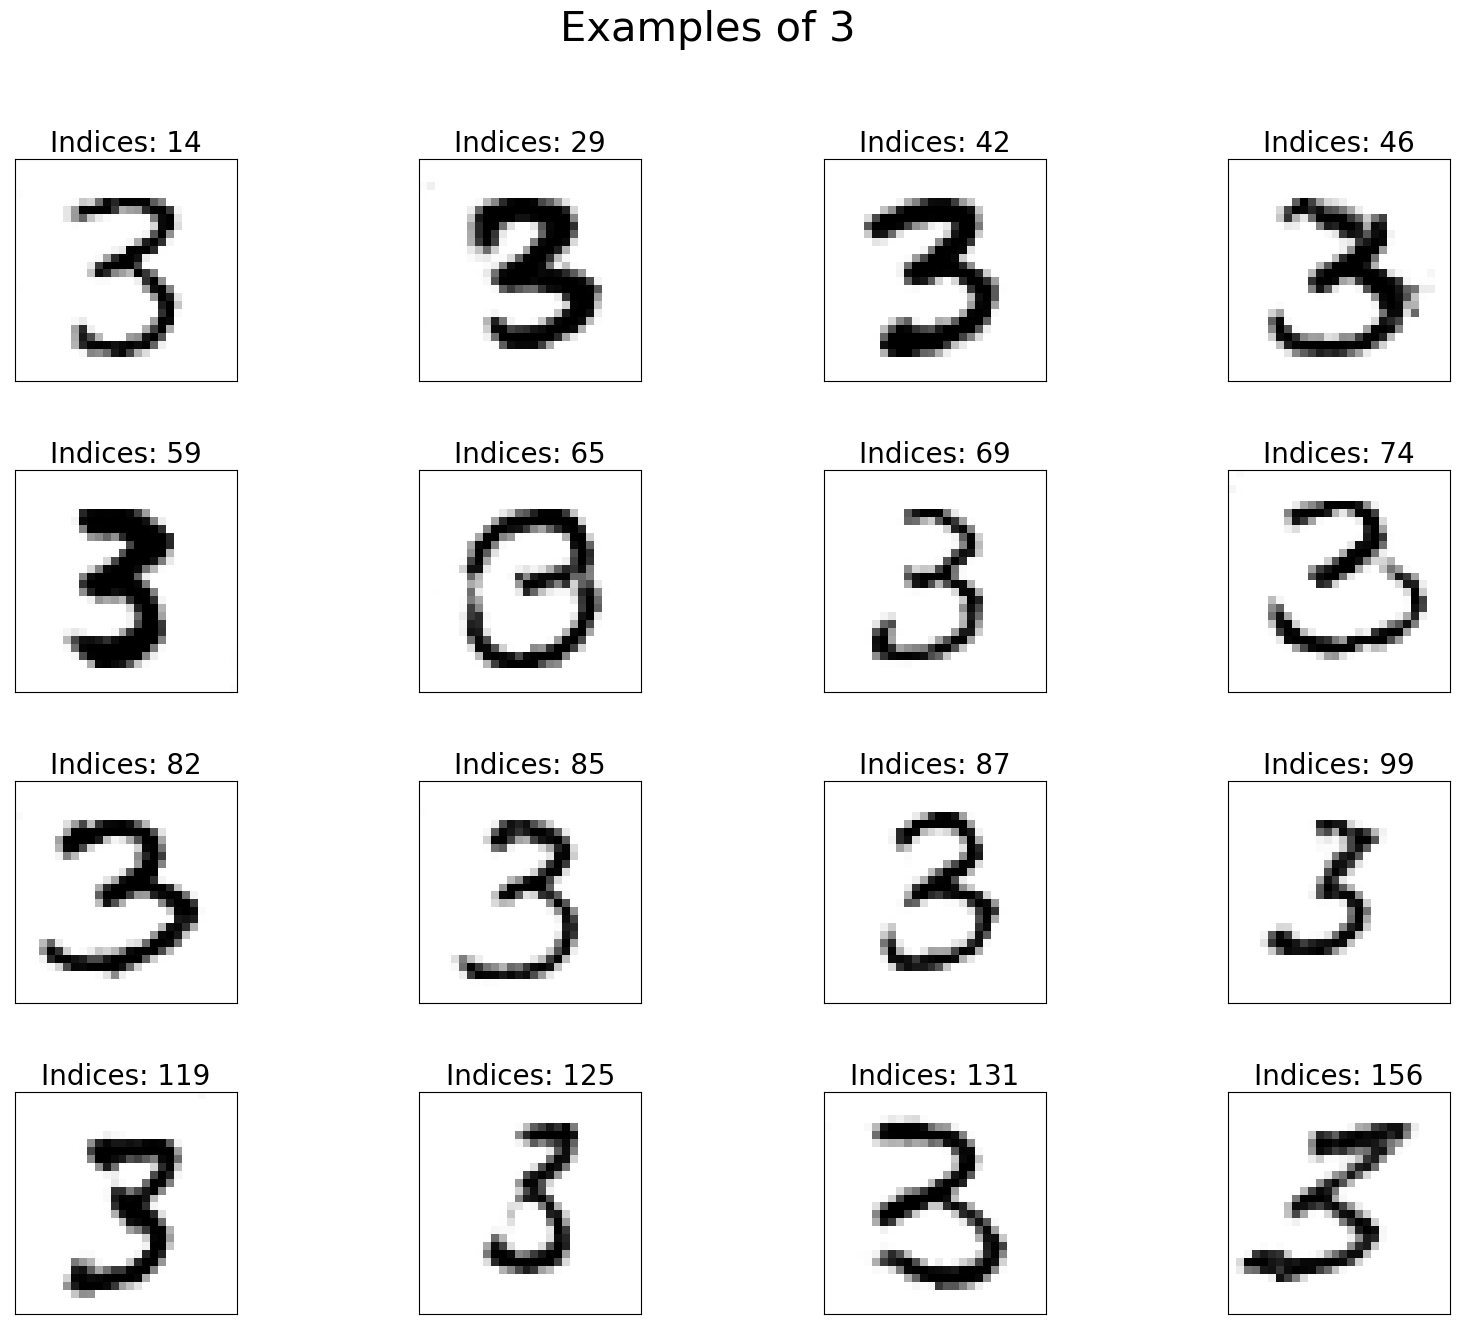

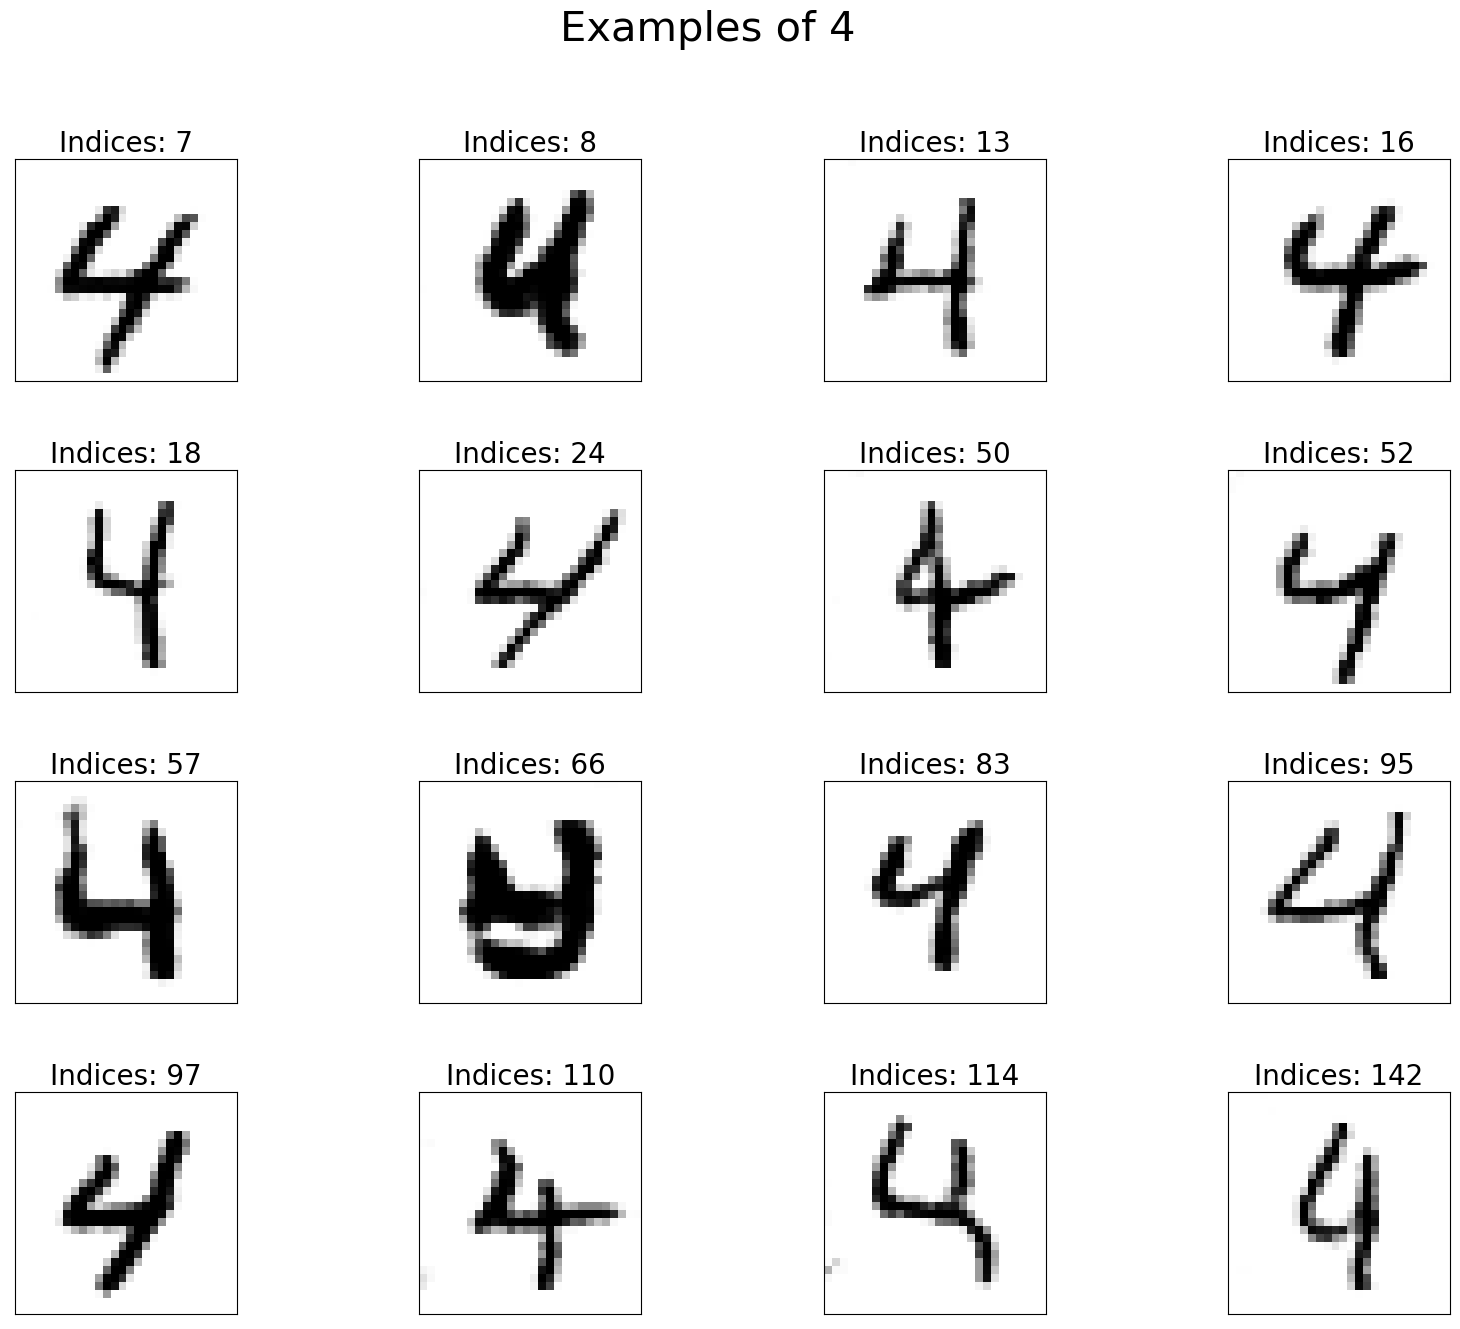

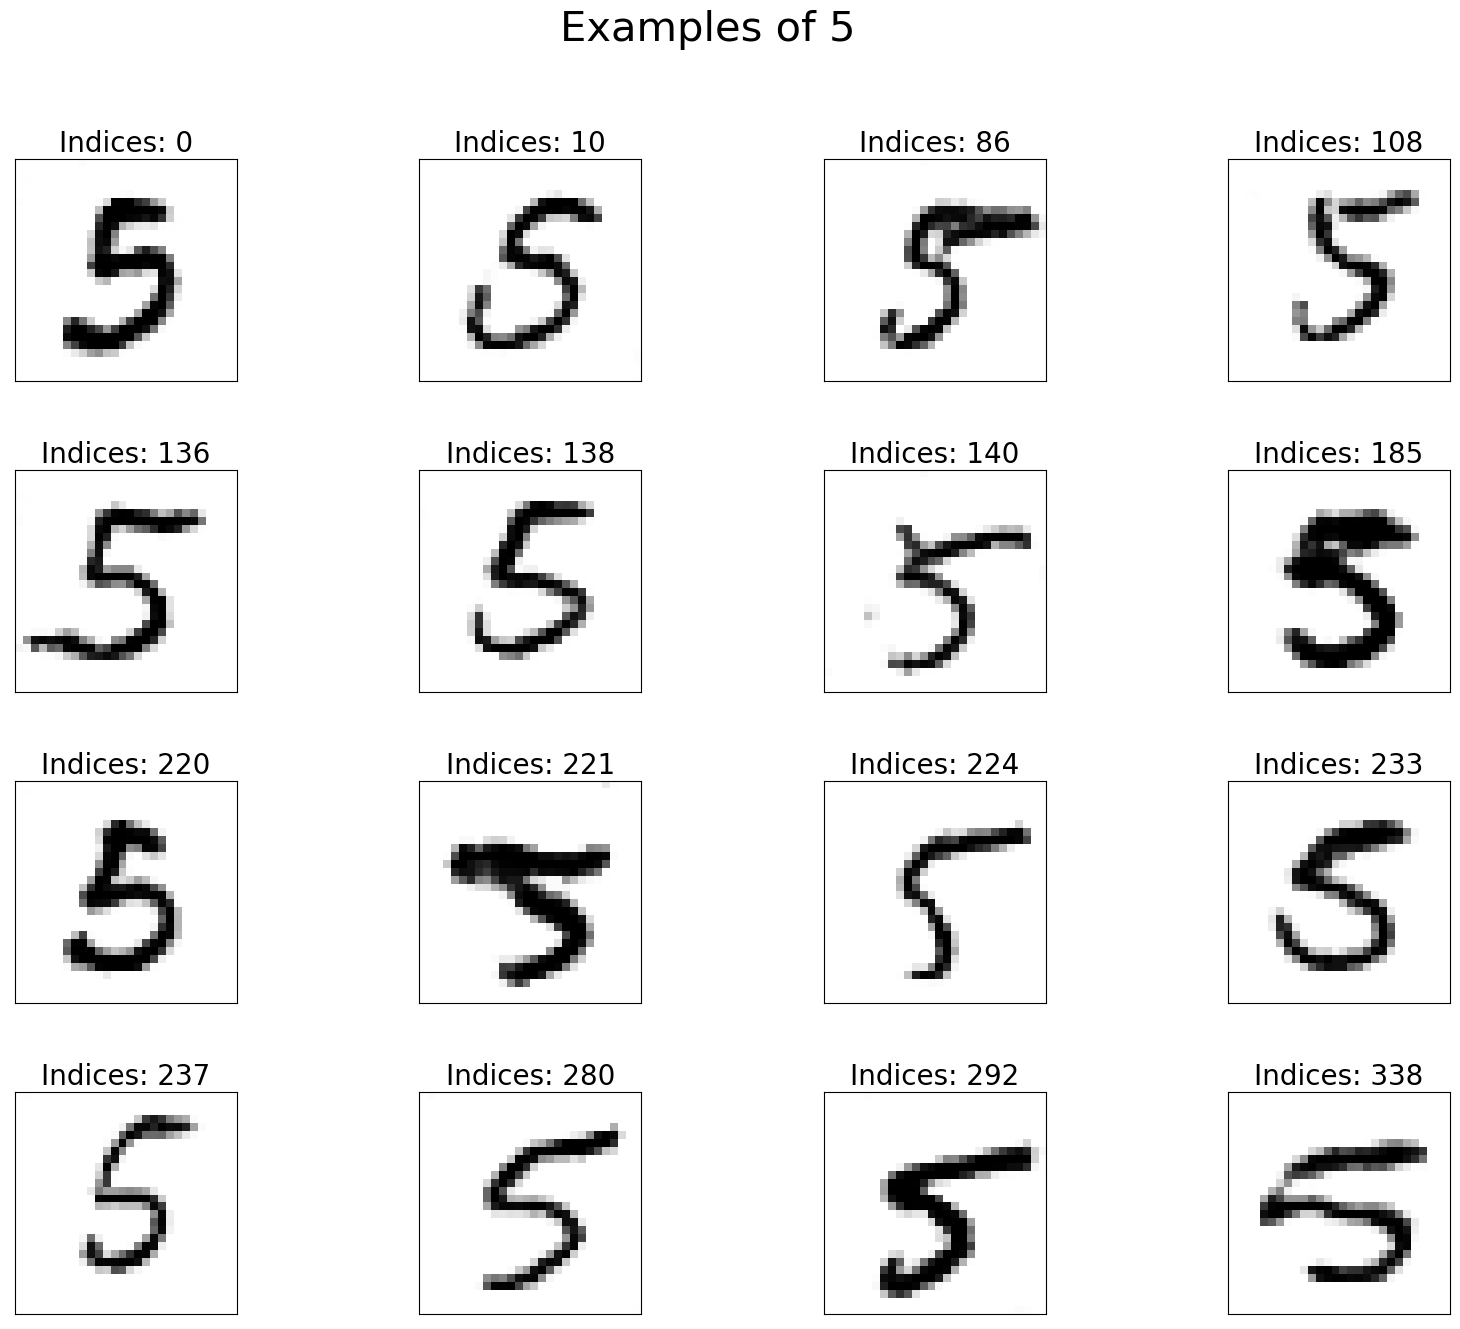

In [70]:
# Plot some images to find our extremes
extreme_labels = [3,4,5]

for extreme_label in extreme_labels:
    mask = (labels == extreme_label)
    indices_label = torch.arange(labels.shape[0]).to(device)[mask]
    
    latents_label = latents[indices_label]
    imgs_label = imgs[indices_label].cpu().detach().numpy()
    
    f = plt.figure(f"Examples of {extreme_label}", figsize = (20,15))
    f.suptitle(f"Examples of {extreme_label}", fontsize = 30)

    f.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.rc('axes', titlesize=20)
    
    for i in range(16):
            fi = f.add_subplot(4, 4, i + 1)
            
            fi.imshow(imgs_label[i].reshape(28, 28), cmap="gray_r")
            plt.xticks([])
            plt.yticks([]) 

            fi.title.set_text(f"Indices: {indices_label[i]}")

    plt.show()

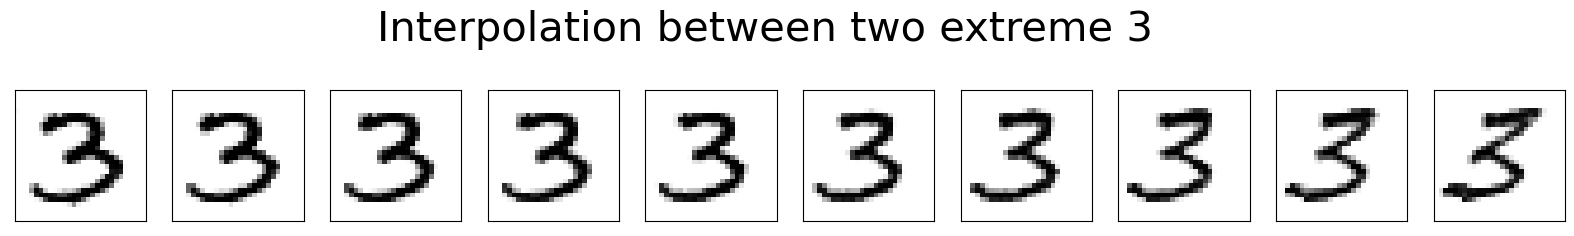

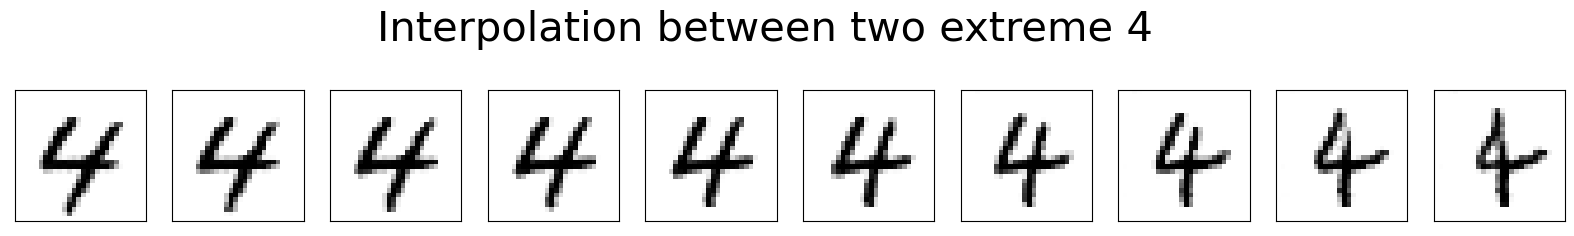

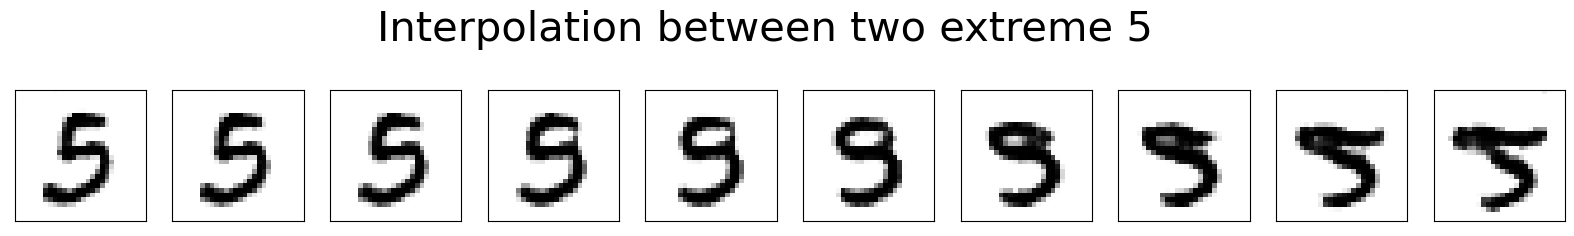

In [71]:
# Plot interpolation from two extremes of the same label
# To update from graph above
ind = [[3, 82, 156], [4, 7, 50], [5, 0, 221]]

n_steps = 10

for i, j, k in ind:
    f = plt.figure(f"Interpolation between two extreme {i}", figsize = (20,3))
    f.suptitle(f"Interpolation between two extreme {i}", fontsize = 30)

    f.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.rc('axes', titlesize=20)
    
    start = latents[j]
    end   = latents[k]
    
    for l in range(n_steps):
        latent = torch.lerp(start, end, l * 1/(n_steps - 1)).to(device)
        img = generator(latent).cpu().detach().numpy()
        
        fi = f.add_subplot(1, n_steps, l + 1)
        fi.imshow(img.reshape(28, 28), cmap="gray_r")
        
        plt.xticks([])
        plt.yticks([]) 
    plt.savefig(f"./Figures/Inter_{i}.png")

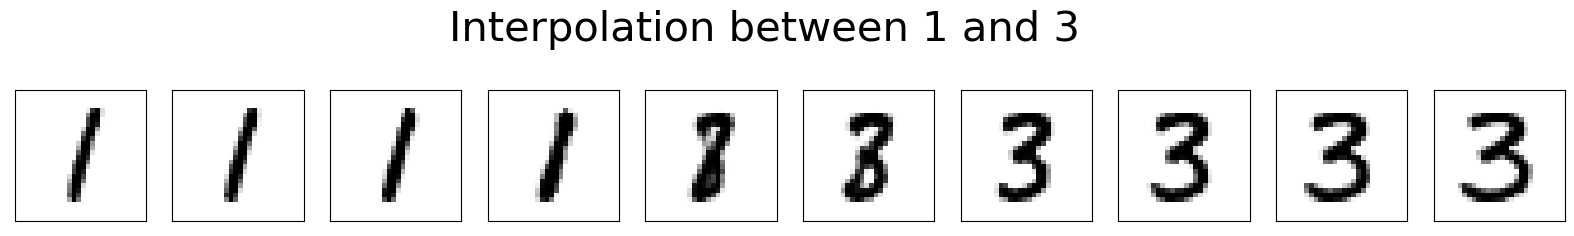

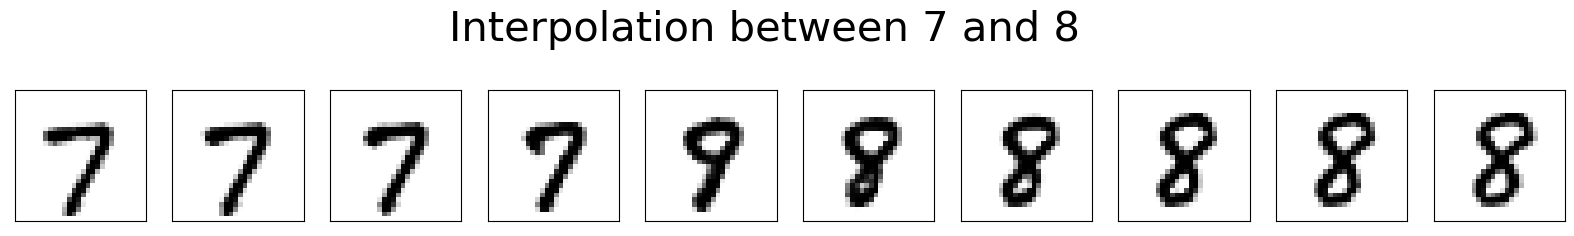

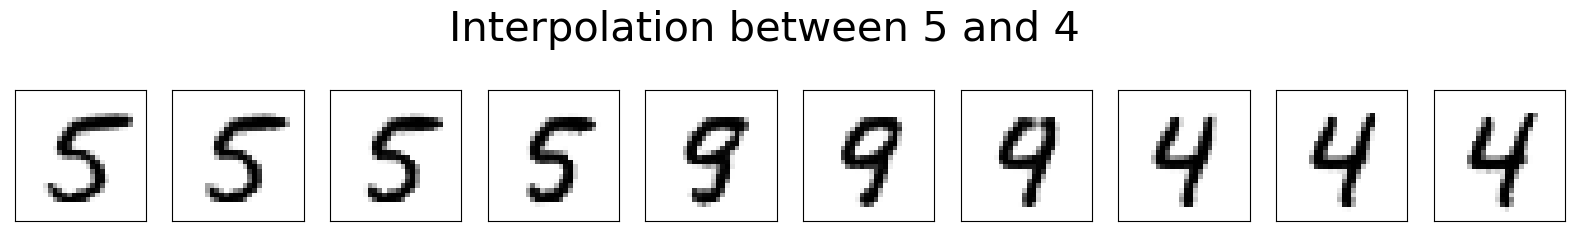

In [72]:
# Plot interpolation from two different labels
labels_pairs = [[1, 3], [7, 8], [5, 4]]
n_steps = 10

for i, j in labels_pairs:
    f = plt.figure(f"Interpolation between {i} and {j}", figsize = (20,3))
    f.suptitle(f"Interpolation between {i} and {j}", fontsize = 30)

    f.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.rc('axes', titlesize=20)
    
    start = latents_avg[i]
    end   = latents_avg[j]
    
    for l in range(n_steps):
        latent = torch.lerp(start, end, l * 1/(n_steps - 1)).to(device)
        img = generator(latent).cpu().detach().numpy()
        
        fi = f.add_subplot(1, n_steps, l + 1)
        fi.imshow(img.reshape(28, 28), cmap="gray_r")
        
        plt.xticks([])
        plt.yticks([]) 
        
    plt.savefig(f"./Figures/Inter_{i}_{j}.png")

## 3.6 Noise for exploration
Generate ”noise latent vectors” with 0 < σ < 1: either from a normal zero-mean distribution (sampled in
N (0, σIdim lat ) ), either from a uniform distribution (sampled from [−σ, σ]dim lat ). You then add those noise vectors
5to the mean latent vectors to create ”variation latent vectors”. These vectors are close variations of the mean latent
vectors, i.e. they are neighbours in the latent space. Compare your variation latent vectors with the mean latent
vector, in terms of labels and in terms of visual quality. Then, analyze the impact of the value of σ (how far from
the mean latent vectors) on the variation latent vectors. More precisely, try σ ∈ {0.1, 0.3, 0.5, 0.7, 0.9}.

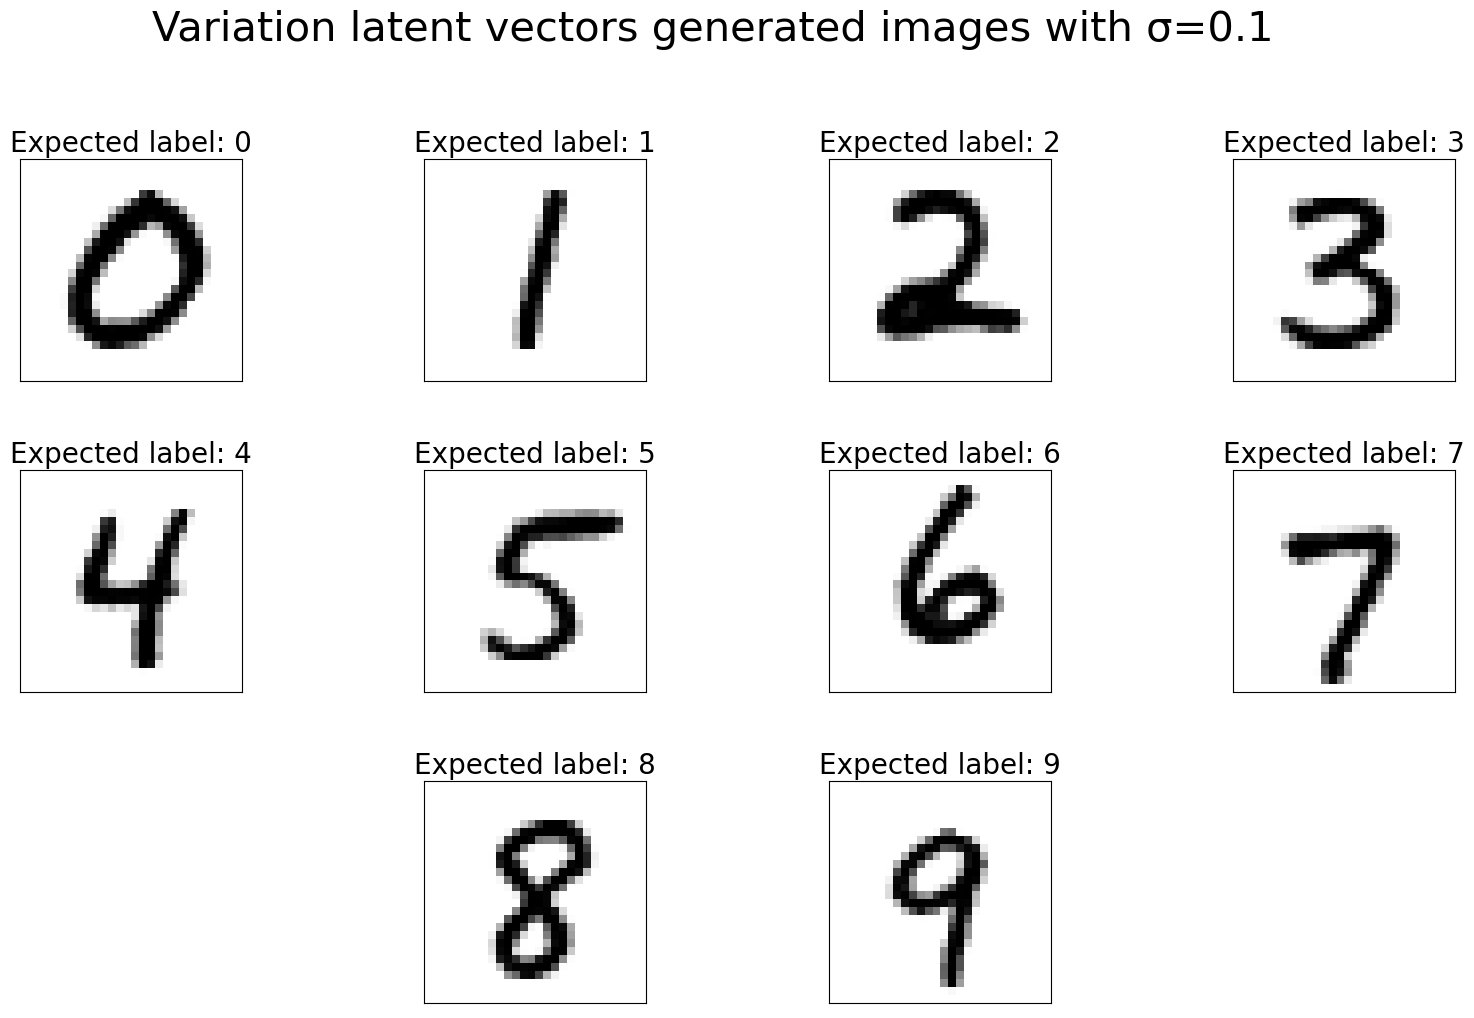

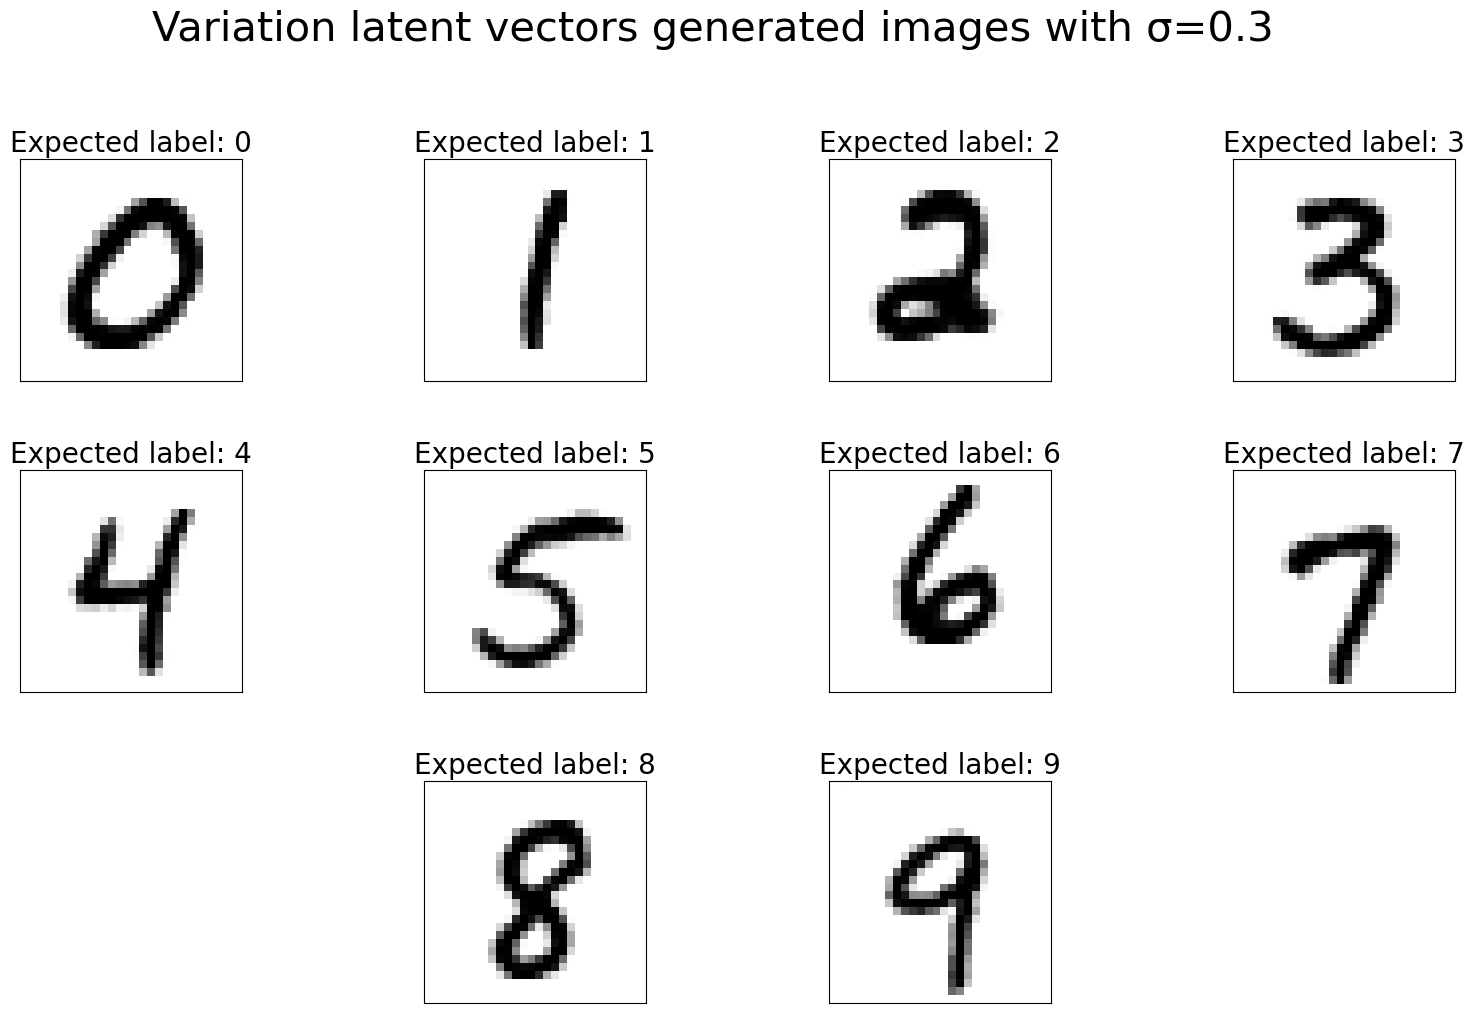

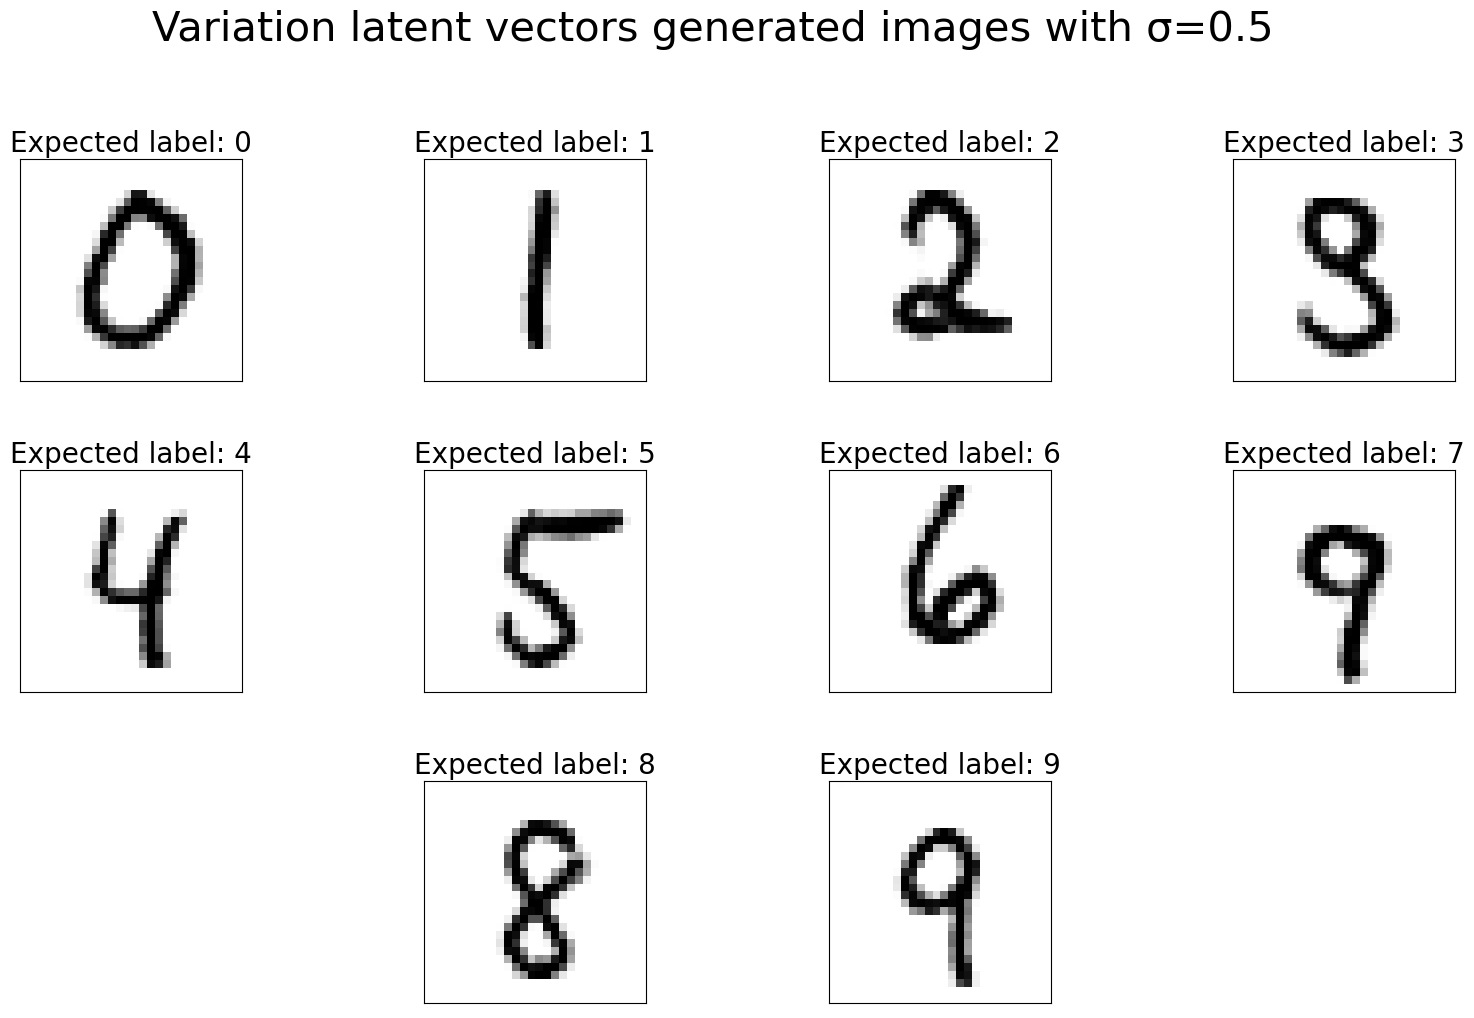

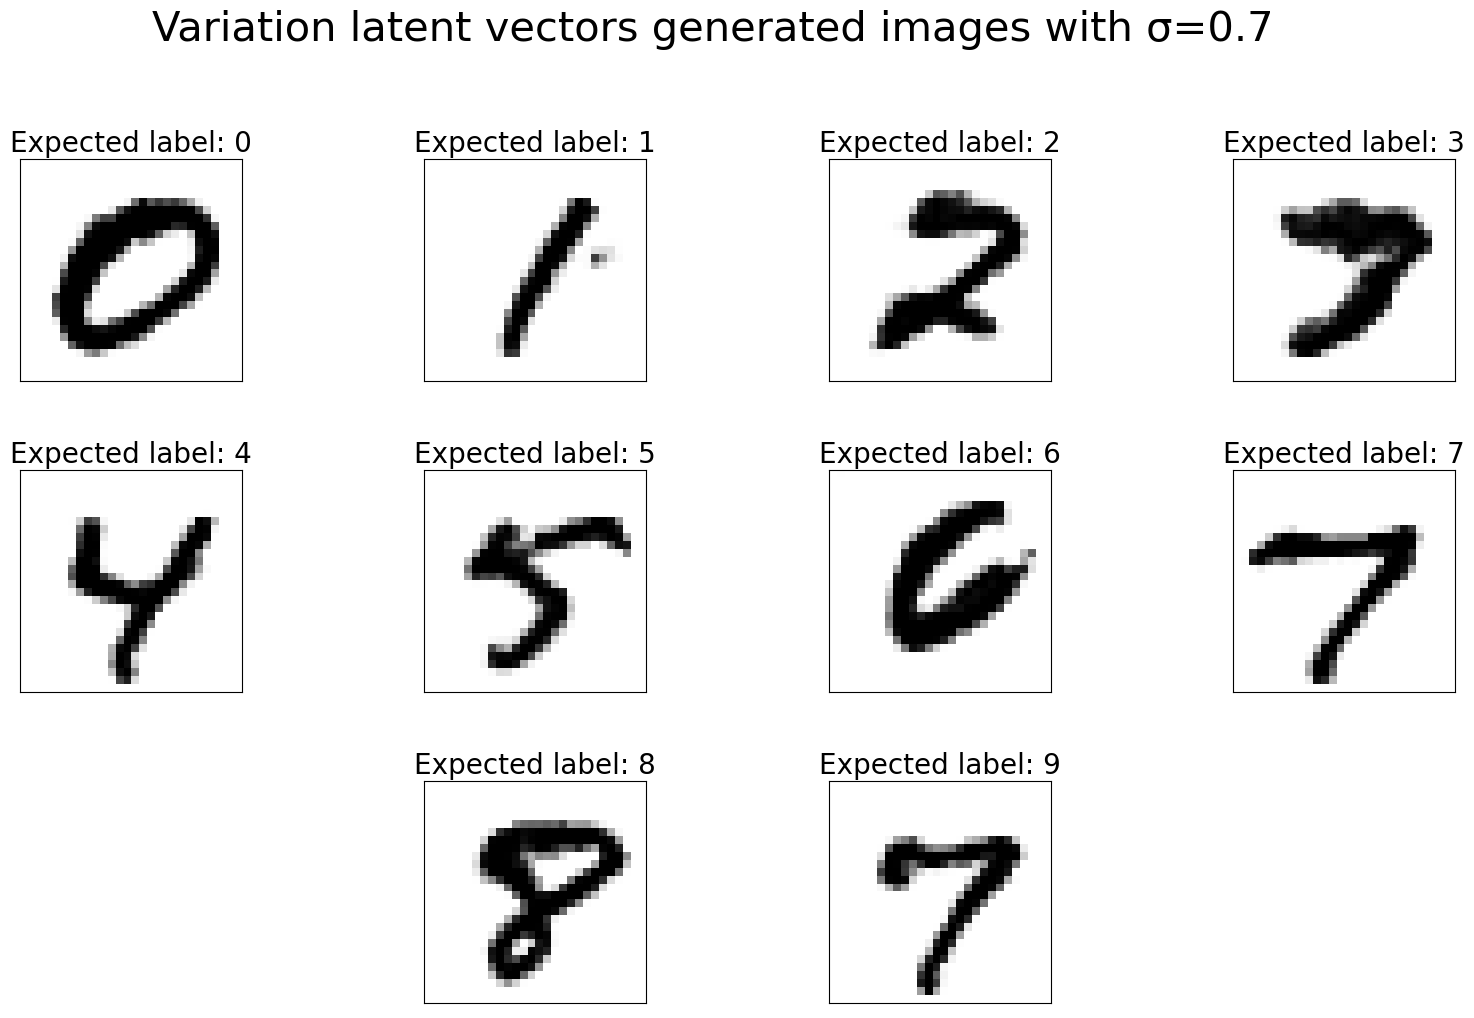

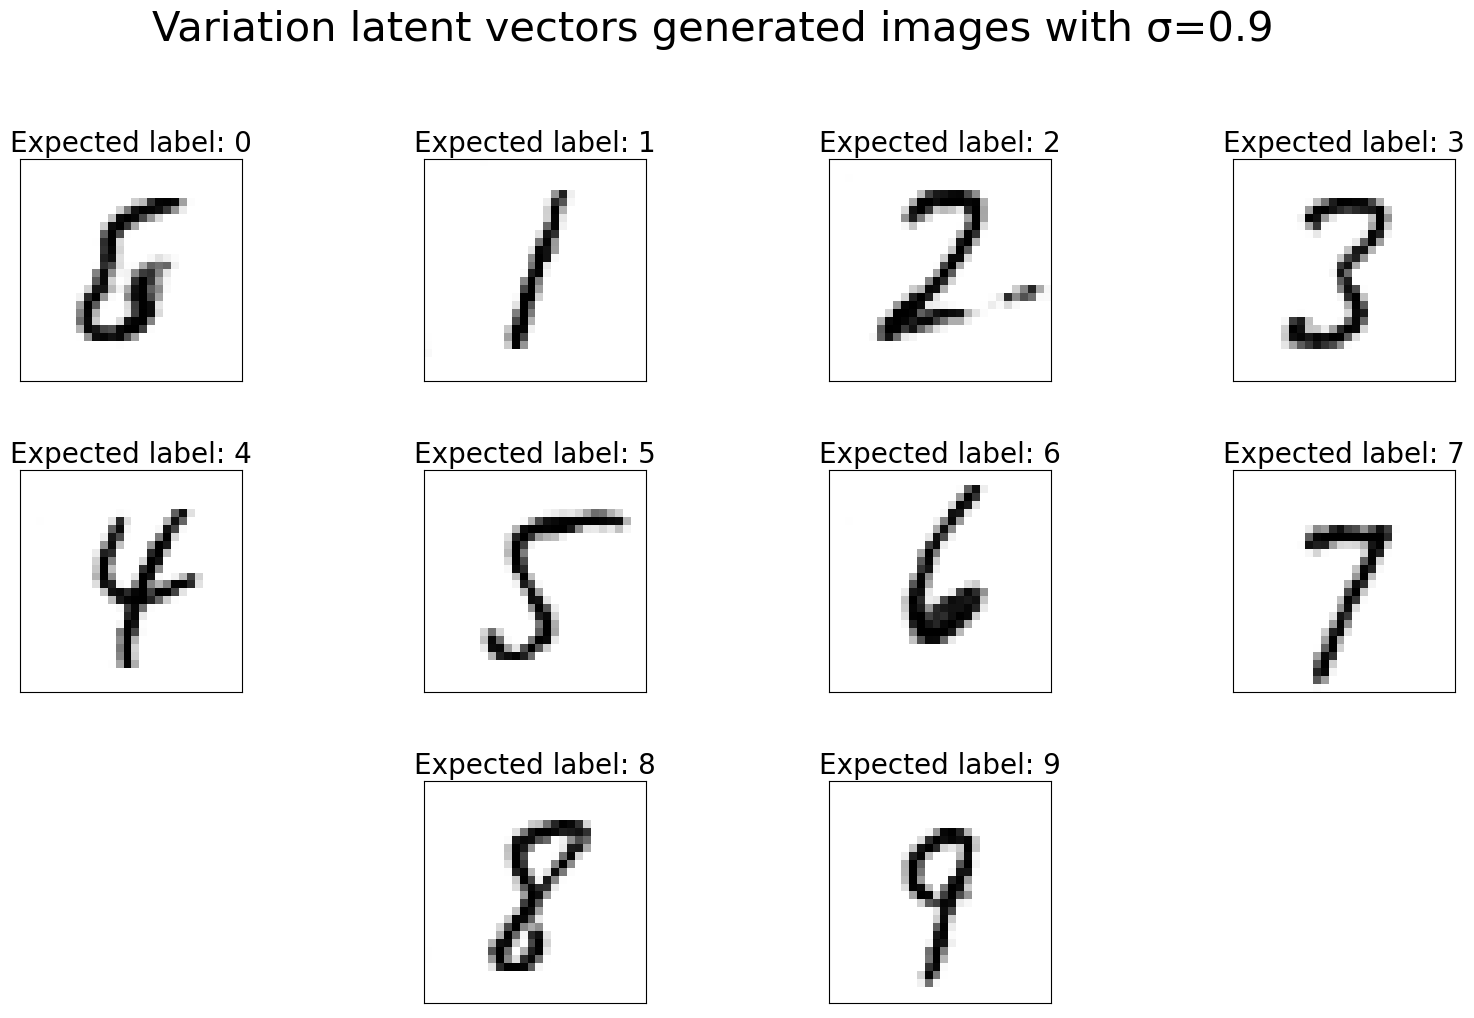

In [73]:
for std in [.1, .3, .5, .7, .9]:
    noise = torch.normal(0, std, size=(dim_latent_space,)).repeat(10,1)
    latents_variation = latents_avg.to(device)+noise.to(device)
    fake_variation = generator(latents_variation).cpu().detach().numpy()
    
    f = plt.figure(f"Variation latent vectors generated images with σ={std}", figsize = (20,15))
    f.suptitle(f"Variation latent vectors generated images with σ={std}", fontsize = 30)

    f.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.rc('axes', titlesize=20)

    for i in range(10):
            if i < 8: fi = f.add_subplot(4, 4, i + 1)
            else: fi = f.add_subplot(4, 4, i + 2) # For esthetic purposes, it centers the last row
            
            fi.imshow(fake_variation[i].reshape(28, 28), cmap="gray_r")
            
            plt.xticks([])
            plt.yticks([]) 

            fi.title.set_text(f"Expected label: {i}")
    
    plt.savefig(f"./Figures/variation_latent_std_{std}.png")

# Section 4.
Create what you want

## 4.1 Mandatory: Open message
You are asked to generate one list of digits/letters that will represent one message. Therefore, you have to find
corresponding latent vectors that we call the ”message latent vectors” and put them, in order, in a PyTorch tensor.
Then, you have to save it in a file thanks to the saveLatentVectors function provided below. You can also load
previously saved latent vectors with loadLatentVectors.

In [74]:
!mkdir Latent_Vectors

mkdir: cannot create directory ‘Latent_Vectors’: File exists


In [75]:
def saveLatentVectors(filename, vector):
    torch.save(vector, "./Latent_Vectors/" + filename)

def loadLatentVectors(filename):
    return torch.load("./Latent_Vectors/" + filename)

In [76]:
#saveLatentVectors("avgLatentVectors", latents_avg)
latents_avg = loadLatentVectors("avgLatentVectors")

In [84]:
# Generate the latent vectors of the message

msg = "1104"
latents_msg = latents_avg[int(msg[0])]
for i in msg[1:]:
    i = int(i)
    latents_msg = torch.vstack((latents_msg, latents_avg[i]))

saveLatentVectors("msgLatentVectors", latents_msg)

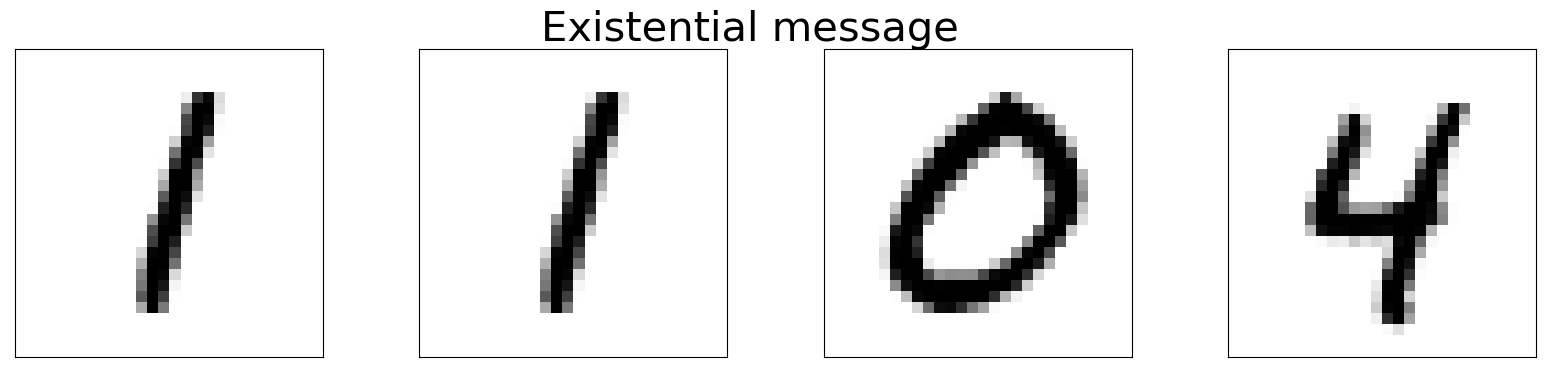

In [85]:
f = plt.figure(f"Existential message", figsize = (20,4))
f.suptitle(f"Existential message", fontsize = 30)

f.subplots_adjust(wspace=0.2, hspace=0.4)
plt.rc('axes', titlesize=20)

for i in range(len(msg)):
    number = generator(latents_msg[i].to(device)).cpu().detach().numpy()
    
    fi = f.add_subplot(1, len(msg), i + 1)
    fi.imshow(number.reshape(28, 28), cmap="gray_r")
    
    plt.xticks([])
    plt.yticks([]) 